# Цель проекта.
Необходимо построить модель, которая предскажет температуру стали, для обеспечения уменьшения потребления электроэнергии.

In [1]:
#!pip install optuna

     |████████████████████████████████| 365 kB 1.4 MB/s eta 0:00:01


Импорт библиотек.

In [2]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import shap

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from catboost import CatBoostRegressor,Pool, cv
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor
 

Объявление констант

In [3]:
RANDOM_STATE = 80523
TEST_SIZE = .25

# Часть 1.
Цель - провести первичный анализ данных и составить план проекта.

## Первичный анализ данных.

In [4]:
file_name = [['data_arc_new', 'Данные об электродах']
             ,['data_bulk_new', 'Данные о подаче сыпучих материалов (объём)']
             ,['data_bulk_time_new', 'Данные о подаче сыпучих материалов (время)']
             ,['data_gas_new', 'Данные о продувке сплава газом']
             ,['data_temp_new', 'Результаты измерения температуры']
             ,['data_wire_new', 'Данные о проволочных материалах (объём)']
             ,['data_wire_time_new', 'Данные о проволочных материалах (время)']]

path = '/datasets/'
if not os.path.exists(path):
    path = 'datasets/'
    
data=dict()



for i in file_name:
    data[i[0]]=pd.read_csv(path+i[0]+'.csv')
    print(f'\033[1m {i[1]} в файле {i[0]} \033[0m')
    data[i[0]].info()
      

 Данные об электродах в файле data_arc_new 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
 Данные о подаче сыпучих материалов (объём) в файле data_bulk_new 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-nu

Количество уникальных партий в различных файлах.

In [5]:
for i in file_name:
    print(f'\033[1m {i[1]} в файле {i[0]} \033[0m')
    print(f'Количество партий : ',len(data[i[0]]['key'].unique()))

 Данные об электродах в файле data_arc_new 
Количество партий :  3214
 Данные о подаче сыпучих материалов (объём) в файле data_bulk_new 
Количество партий :  3129
 Данные о подаче сыпучих материалов (время) в файле data_bulk_time_new 
Количество партий :  3129
 Данные о продувке сплава газом в файле data_gas_new 
Количество партий :  3239
 Результаты измерения температуры в файле data_temp_new 
Количество партий :  3216
 Данные о проволочных материалах (объём) в файле data_wire_new 
Количество партий :  3081
 Данные о проволочных материалах (время) в файле data_wire_time_new 
Количество партий :  3081


Первые строки каждого датафрейма.

In [6]:
for i in file_name:
    print(f'\033[1m {i[1]} в файле {i[0]} \033[0m')
    print(data[i[0]].head())

 Данные об электродах в файле data_arc_new 
   key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
0    1  2019-05-03 11:02:14  2019-05-03 11:06:02           0.305130   
1    1  2019-05-03 11:07:28  2019-05-03 11:10:33           0.765658   
2    1  2019-05-03 11:11:44  2019-05-03 11:14:36           0.580313   
3    1  2019-05-03 11:18:14  2019-05-03 11:24:19           0.518496   
4    1  2019-05-03 11:26:09  2019-05-03 11:28:37           0.867133   

   Реактивная мощность  
0             0.211253  
1             0.477438  
2             0.430460  
3             0.379979  
4             0.643691  
 Данные о подаче сыпучих материалов (объём) в файле data_bulk_new 
   key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0    1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN   
1    2     NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN   
2    3     NaN     NaN     NaN    34.0     NaN     NaN     NaN     NaN   
3    4     NaN  

Стат характеристики датафреймов.

In [7]:
for i in file_name:
    print(f'\033[1m {i[1]} в файле {i[0]} \033[0m')
    print(data[i[0]].describe(percentiles=[.01,.10,.25,.5,.75,.90,.99]))

 Данные об электродах в файле data_arc_new 
                key  Активная мощность  Реактивная мощность
count  14876.000000       14876.000000         14876.000000
mean    1615.220422           0.662752             0.438986
std      934.571502           0.258885             5.873485
min        1.000000           0.223120          -715.479924
1%        33.000000           0.270028             0.193644
10%      322.000000           0.369425             0.267902
25%      806.000000           0.467115             0.337175
50%     1617.000000           0.599587             0.441639
75%     2429.000000           0.830070             0.608201
90%     2913.000000           1.041155             0.775249
99%     3205.000000           1.335955             1.032311
max     3241.000000           1.463773             1.270284
 Данные о подаче сыпучих материалов (объём) в файле data_bulk_new 
               key      Bulk 1      Bulk 2       Bulk 3       Bulk 4  \
count  3129.000000  252.000000   22.0

Построим бокс плоты для данных.

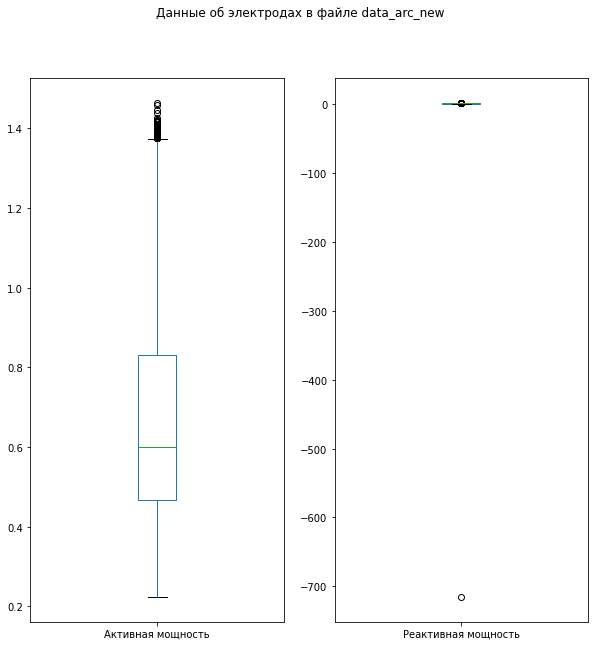

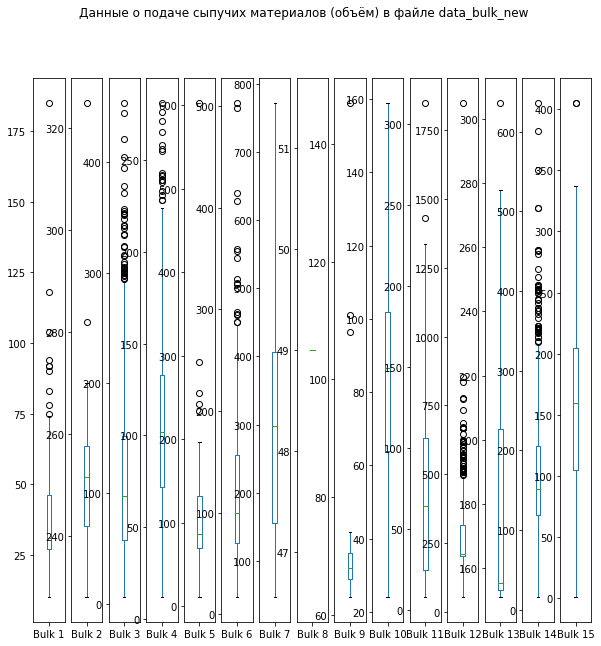

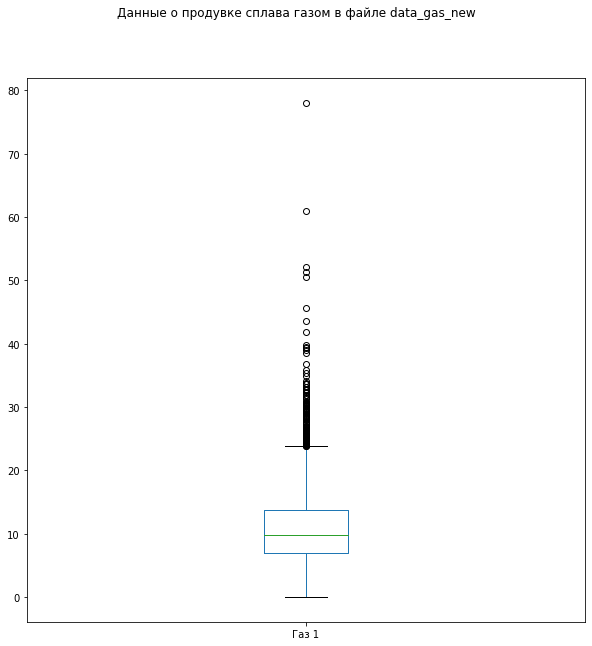

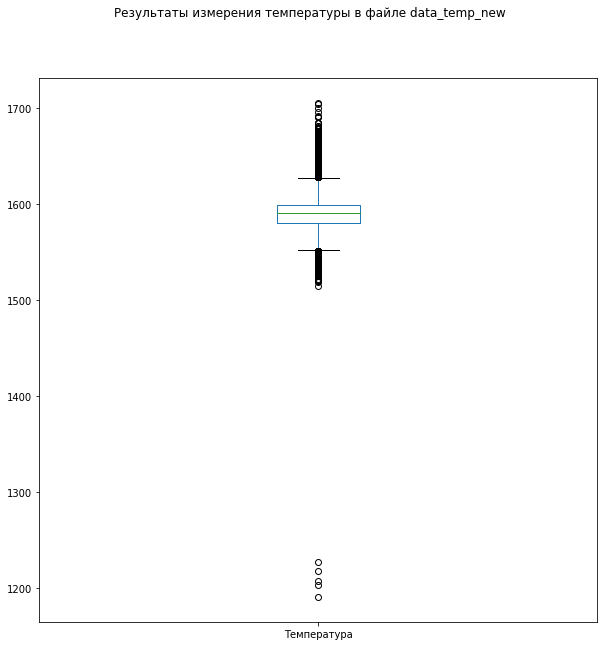

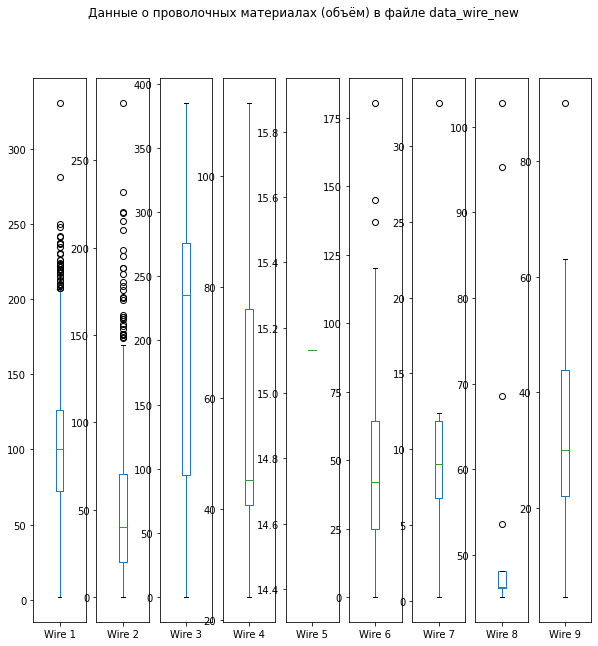

In [8]:
for i in file_name:
    if i[0] not in ['data_bulk_time_new','data_wire_time_new']:
        data[i[0]][list(data[i[0]].columns[1:])].plot(kind='box',figsize=(10,10),subplots=True,rot = 0
                                                      ,title=f'{i[1]} в файле {i[0]}');

### Замечания к данным:
1. Число партий различно в разных файлах (есть пропуски, должно быть 3241 партия, а не в одном датафрейме столько нет)- необходимо либо удалить пропущенные данные, либо восстановить используя медианное или среднее значение, для будущего объединения.  
2. На boxplot явно видны аномальные выбросы в реактивной мощности(отрицательное значение) и в температуре(несколько низких значений, при том что плавление стали от 1300 градусов) и продувке газом (несколько завышенных значений) - либо удалить "некорректные" данные или заменить их на медианное или среднее значение.
3. По суммарному просмотру статистических данных и boxplot среди объемов добавления "аномалий" не увидел. Большой разброс там присутствует-где очень много значений.(что возможно связано с технологическим процессом, можно уточнить у заказчика)
4. Для указания времени изпользуется тип данных object. - требуется поменять тип данных
5. Столбцы названы в разнобой, где-то кириллицей, где-то латиницей. - привести к общему виду.


### На данном этапе были сформировнны следующие вопросы для получения уточнения у заказчика:
1. Если данные о подаче конкретных типов сыпучих материалов или проволоки отсутствуют, значит на этом шаге подача данных типов материалов отсутствовала?
2. Вопрос об аномальных данных температуры 1200 градусов-может ли такая температура быть у доменной печи в рабочем состоянии ( при первом включении)
3. Существуют ли нижние и верхние границы объема добавления сыпучих материалов и проволоки, для каждого материала по технологии? 

### Ответы:  
1. Да, верно. И можно ставить 0 - нет присадок.  
2. В случае с температурой плавления: по справочнику она у металла = около 1400+-, т.е. 1200 - действиетльно кажется очень странным значением. А 1450 и выше выглядит вполне рабочим, не смотря на статистические границы.  
3. По регламенту на заводе точно есть. Но у нас в распоряжении - нет

### План работ:
1. Очистить данные и объединить датафреймы.
2. Продумать несколько моделей которые можно использовать. Т.к. показатель темпеатура-модель регрессионная. Продумать метрики.
3. Проверить модели на валидационной выборке. Выбрать лучшую.
4. Проверить модель на тестовой выборке.



# Часть 2.
Цель - предобработка данных, построение модели.

## Предобработка данных.
### Исправление типа данных и имен столбцов.

In [9]:
data['data_arc_new'].columns = ['key','start_heating','stop_heating','active_power','reactive_power']
data['data_temp_new'].columns = ['key','sample_time','temp']
data['data_gas_new'].columns = ['key','gas_1']

In [10]:
for i in file_name:
    data[i[0]].columns = [re.sub(r' ','_',i).lower() for i in data[i[0]].columns]
    data[i[0]][data[i[0]].columns[data[i[0]].dtypes == 'object']] = data[i[0]][data[i[0]]\
                                                                               .columns[data[i[0]].dtypes == 'object']]\
                                                                                .apply(pd.to_datetime)
    


In [11]:
for i in file_name:
    print(f'\033[1m {i[1]} в файле {i[0]} \033[0m')
    data[i[0]].info()

 Данные об электродах в файле data_arc_new 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   key             14876 non-null  int64         
 1   start_heating   14876 non-null  datetime64[ns]
 2   stop_heating    14876 non-null  datetime64[ns]
 3   active_power    14876 non-null  float64       
 4   reactive_power  14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB
 Данные о подаче сыпучих материалов (объём) в файле data_bulk_new 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   252 non-null    float64
 2   bulk_2   22 non-null     float64
 3   bulk_3   1298 non-null   float64
 4   bulk_4

### Создание объединенного dataframe модели (data_model) и заполнение его. 
#### Определение номеров партий (key) присутствующих во всех файлах

In [12]:
key_model = set(data[file_name[0][0]]['key'].unique())
for i in file_name: 
    if i[0] not in ['data_wire_time_new','data_bulk_time_new']:
        key_model = key_model & set(data[i[0]][data[i[0]][data[i[0]].columns[1:]].sum(axis=1)!=0]['key'].unique())
        print(len(key_model))
len(key_model)

3214
3128
3126
3126
3022


3022

In [13]:
key_model = set(data[file_name[0][0]]['key'].unique())
for i in file_name[1:]:
    key_model = key_model & set(data[i[0]]['key'].unique())
len(key_model)

3022

In [14]:
data_model = pd.DataFrame(key_model, columns = ['key'])
data_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3022 entries, 0 to 3021
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   key     3022 non-null   int64
dtypes: int64(1)
memory usage: 23.7 KB


#### Добавляем данные из файла data_arc_new

In [15]:
data_arc_new = data['data_arc_new'].copy()
data_arc_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   key             14876 non-null  int64         
 1   start_heating   14876 non-null  datetime64[ns]
 2   stop_heating    14876 non-null  datetime64[ns]
 3   active_power    14876 non-null  float64       
 4   reactive_power  14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


Додавим два интервала - интервал работы(нагрева) и интервал простоя(между нагревами).

In [16]:
data_arc_new['interval_idle']=(data_arc_new[data_arc_new['key']==data_arc_new['key'].shift()]['start_heating']
                     -data_arc_new['stop_heating'].shift()
                    ).dt.seconds
data_arc_new['interval_job'] = (data_arc_new['stop_heating']-data_arc_new['start_heating']).dt.seconds
data_arc_new.head(20)

,key,start_heating,stop_heating,active_power,reactive_power,interval_idle,interval_job
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,NaN,228
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,86.0,185
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,71.0,172
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,218.0,365
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,110.0,148
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351,NaN,137
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527,139.0,338
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962,111.0,126
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517,83.0,210
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856,NaN,280


При исследовании установлено, что в значениях реактивной мощности("reactive_power") имеются выбросы.  
При моделировании не будем ее использовать, т.к. активная мощность - полещная мощность используемая на нагрев(что нам и требуется). (https://skat-ups.ru/vopros-otvet/activnaya-reactivnaya-mojnost/#:~:text=%D0%90%D0%BA%D1%82%D0%B8%D0%B2%D0%BD%D0%B0%D1%8F%20%D0%BC%D0%BE%D1%89%D0%BD%D0%BE%D1%81%D1%82%D1%8C%20%E2%80%94%20%D1%8D%D1%82%D0%BE%20%D0%BF%D0%BE%D0%BB%D0%B5%D0%B7%D0%BD%D0%B0%D1%8F%20%D1%87%D0%B0%D1%81%D1%82%D1%8C,%D0%B2%20%D0%B4%D1%80%D1%83%D0%B3%D0%B8%D0%B5%20%D0%BD%D0%B5%D0%BE%D0%B1%D1%85%D0%BE%D0%B4%D0%B8%D0%BC%D1%8B%D0%B5%20%D0%B2%D0%B8%D0%B4%D1%8B%20%D1%8D%D0%BD%D0%B5%D1%80%D0%B3%D0%B8%D0%B8.)  
Введем дополнительный столбец-интервал работ умноженный на активную мощность.

In [17]:
data_arc_new['active'] = data_arc_new['active_power'] * data_arc_new['interval_job']
data_arc_new.head(10)

,key,start_heating,stop_heating,active_power,reactive_power,interval_idle,interval_job,active
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,NaN,228,69.569640
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,86.0,185,141.646730
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,71.0,172,99.813836
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,218.0,365,189.251040
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,110.0,148,128.335684
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351,NaN,137,52.213988
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527,139.0,338,88.442770
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962,111.0,126,89.497422
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517,83.0,210,165.127620
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856,NaN,280,308.469840


Сгруппируем теперь данные по партиям ('key').

In [18]:
data_arc_new_group = data_arc_new.groupby('key')[['interval_idle','active']].sum()
data_arc_new_group.columns = ['interval_idle','active_power']
data_arc_new_group.head()

,interval_idle,active_power
key,,
1,485.0,628.616930
2,333.0,395.281800
3,870.0,581.774624
4,352.0,543.710274
5,493.0,412.180480


Добавим данные в data_model.

In [19]:
data_model = data_model.merge(data_arc_new_group, on='key', how='left')
data_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3022 entries, 0 to 3021
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   key            3022 non-null   int64  
 1   interval_idle  3022 non-null   float64
 2   active_power   3022 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 94.4 KB


In [20]:
data_model.head()

,key,interval_idle,active_power
0,1,485.0,628.616930
1,2,333.0,395.281800
2,3,870.0,581.774624
3,4,352.0,543.710274
4,5,493.0,412.180480


#### Добавляем данные из файла data_bulk_new

In [21]:
data_bulk = data['data_bulk_new']
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   252 non-null    float64
 2   bulk_2   22 non-null     float64
 3   bulk_3   1298 non-null   float64
 4   bulk_4   1014 non-null   float64
 5   bulk_5   77 non-null     float64
 6   bulk_6   576 non-null    float64
 7   bulk_7   25 non-null     float64
 8   bulk_8   1 non-null      float64
 9   bulk_9   19 non-null     float64
 10  bulk_10  176 non-null    float64
 11  bulk_11  177 non-null    float64
 12  bulk_12  2450 non-null   float64
 13  bulk_13  18 non-null     float64
 14  bulk_14  2806 non-null   float64
 15  bulk_15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


Объединим столбцы с заполненностью меннее 500 и удалим их.

In [22]:
list_bulk = ['bulk_1','bulk_2','bulk_5','bulk_7','bulk_8','bulk_9','bulk_10','bulk_11','bulk_13']
data_bulk['other_bulk'] = data_bulk[list_bulk].sum(axis=1)
data_bulk = data_bulk.drop(columns=list_bulk,axis=1)
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   key         3129 non-null   int64  
 1   bulk_3      1298 non-null   float64
 2   bulk_4      1014 non-null   float64
 3   bulk_6      576 non-null    float64
 4   bulk_12     2450 non-null   float64
 5   bulk_14     2806 non-null   float64
 6   bulk_15     2248 non-null   float64
 7   other_bulk  3129 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 195.7 KB


In [23]:
data_model = data_model.merge(data_bulk, on='key', how='left')

data_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3022 entries, 0 to 3021
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   key            3022 non-null   int64  
 1   interval_idle  3022 non-null   float64
 2   active_power   3022 non-null   float64
 3   bulk_3         1293 non-null   float64
 4   bulk_4         1012 non-null   float64
 5   bulk_6         570 non-null    float64
 6   bulk_12        2356 non-null   float64
 7   bulk_14        2709 non-null   float64
 8   bulk_15        2234 non-null   float64
 9   other_bulk     3022 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 259.7 KB


#### Добавляем данные из файла data_wire_new

In [24]:
data_wire = data['data_wire_new']
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3055 non-null   float64
 2   wire_2  1079 non-null   float64
 3   wire_3  63 non-null     float64
 4   wire_4  14 non-null     float64
 5   wire_5  1 non-null      float64
 6   wire_6  73 non-null     float64
 7   wire_7  11 non-null     float64
 8   wire_8  19 non-null     float64
 9   wire_9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


Объединим столбцы с заполненностью меннее 500 и удалим их.

In [25]:
list_wire = ['wire_3','wire_4','wire_5','wire_6','wire_7','wire_8','wire_9']
data_wire['other_wire'] = data_wire[list_wire].sum(axis=1)
data_wire = data_wire.drop(columns=list_wire,axis=1)
data_wire.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   key         3081 non-null   int64  
 1   wire_1      3055 non-null   float64
 2   wire_2      1079 non-null   float64
 3   other_wire  3081 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 96.4 KB


In [26]:
data_model = data_model.merge(data_wire, on='key', how='left')

data_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3022 entries, 0 to 3021
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   key            3022 non-null   int64  
 1   interval_idle  3022 non-null   float64
 2   active_power   3022 non-null   float64
 3   bulk_3         1293 non-null   float64
 4   bulk_4         1012 non-null   float64
 5   bulk_6         570 non-null    float64
 6   bulk_12        2356 non-null   float64
 7   bulk_14        2709 non-null   float64
 8   bulk_15        2234 non-null   float64
 9   other_bulk     3022 non-null   float64
 10  wire_1         2997 non-null   float64
 11  wire_2         1051 non-null   float64
 12  other_wire     3022 non-null   float64
dtypes: float64(12), int64(1)
memory usage: 330.5 KB


#### Добавляем данные из файла data_gas_new

In [27]:
data_model = data_model.merge(data['data_gas_new'], on='key', how='left')
data_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3022 entries, 0 to 3021
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   key            3022 non-null   int64  
 1   interval_idle  3022 non-null   float64
 2   active_power   3022 non-null   float64
 3   bulk_3         1293 non-null   float64
 4   bulk_4         1012 non-null   float64
 5   bulk_6         570 non-null    float64
 6   bulk_12        2356 non-null   float64
 7   bulk_14        2709 non-null   float64
 8   bulk_15        2234 non-null   float64
 9   other_bulk     3022 non-null   float64
 10  wire_1         2997 non-null   float64
 11  wire_2         1051 non-null   float64
 12  other_wire     3022 non-null   float64
 13  gas_1          3022 non-null   float64
dtypes: float64(13), int64(1)
memory usage: 354.1 KB


#### Добавляем данные из файла data_temp_new

In [28]:
data_temp = data['data_temp_new']
data_temp.head(10)

,key,sample_time,temp
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


Заменим все нулевые значения на заведомо большое число(10000).

In [29]:
sum(data_temp['temp'].isnull())

3427

In [30]:
data_temp.loc[data_temp['temp'].isnull(),['temp']] = 10000
sum(data_temp['temp'].isnull())

0

Выделим значение первой и последней температуры партии('key')

In [31]:
data_temp_fl = data_temp.groupby('key')[['temp']].agg(['first', 'last'])
data_temp_fl.columns = ['first_temp','last_temp']
data_temp_fl.head()

,first_temp,last_temp
key,,
1,1571.0,1613.0
2,1581.0,1602.0
3,1596.0,1599.0
4,1601.0,1625.0
5,1576.0,1602.0


In [32]:
data_temp_fl

,first_temp,last_temp
key,,
1,1571.0,1613.0
2,1581.0,1602.0
3,1596.0,1599.0
4,1601.0,1625.0
5,1576.0,1602.0
...,...,...
3237,1569.0,10000.0
3238,1584.0,10000.0
3239,1598.0,10000.0


In [33]:
data_model = data_model.merge(data_temp_fl, on='key', how='left')
data_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3022 entries, 0 to 3021
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   key            3022 non-null   int64  
 1   interval_idle  3022 non-null   float64
 2   active_power   3022 non-null   float64
 3   bulk_3         1293 non-null   float64
 4   bulk_4         1012 non-null   float64
 5   bulk_6         570 non-null    float64
 6   bulk_12        2356 non-null   float64
 7   bulk_14        2709 non-null   float64
 8   bulk_15        2234 non-null   float64
 9   other_bulk     3022 non-null   float64
 10  wire_1         2997 non-null   float64
 11  wire_2         1051 non-null   float64
 12  other_wire     3022 non-null   float64
 13  gas_1          3022 non-null   float64
 14  first_temp     3022 non-null   float64
 15  last_temp      3022 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 401.4 KB


#### Проверим объединенный dataframe модели (data_model) 
При первичном анализе выявлены аномальные значения температуры (1200), проверим попали ли они в результирующий датасет.

In [34]:
data_model[(data_model['first_temp']<1300) | (data_model['last_temp']<1300)]

,key,interval_idle,active_power,bulk_3,bulk_4,bulk_6,bulk_12,bulk_14,bulk_15,other_bulk,wire_1,wire_2,other_wire,gas_1,first_temp,last_temp
799,867,1461.0,630.106995,264.0,NaN,NaN,206.0,117.0,104.0,0.0,158.511604,35.07608,0.0,11.616807,1191.0,1599.0
1124,1214,1388.0,449.831200,NaN,NaN,NaN,206.0,124.0,101.0,0.0,53.118000,NaN,0.0,12.933558,1208.0,1591.0
1511,1619,151.0,117.210974,45.0,NaN,NaN,NaN,NaN,NaN,0.0,155.141998,45.17968,0.0,4.542025,1218.0,1590.0
1919,2052,1300.0,323.934857,NaN,84.0,NaN,207.0,100.0,103.0,0.0,116.014076,NaN,0.0,8.639928,1227.0,1592.0
2390,2561,827.0,749.240102,NaN,150.0,NaN,204.0,148.0,104.0,0.0,164.193115,NaN,0.0,22.679999,1204.0,10000.0


Удалим данные строки.

In [35]:
data_model = data_model[(data_model['first_temp']>=1300) & (data_model['last_temp']>=1300)]

Заменим Nan на 0.

In [36]:
data_model = data_model.fillna(0)

##### Посмотрим на разброс параметров получившегося датасета

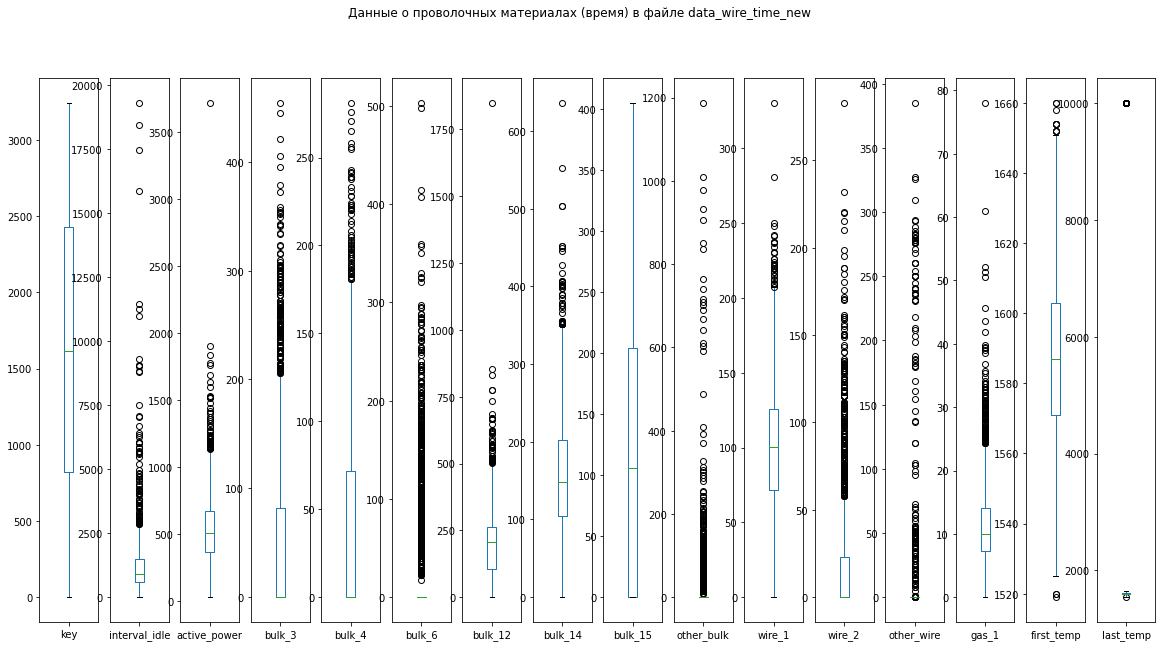

In [37]:
data_model.plot(kind='box',figsize=(20,10),subplots=True,rot = 0
                                                      ,title=f'{i[1]} в файле {i[0]}');

##### Столбец 'first_temp' и 'last_temp'
Удалим аномальные значения в 10000, которые использовали для заполнения пропусков.

In [38]:
data_model = data_model[(data_model['first_temp']<5000) & (data_model['last_temp']<5000)]

In [39]:
data_model

,key,interval_idle,active_power,bulk_3,bulk_4,bulk_6,bulk_12,bulk_14,bulk_15,other_bulk,wire_1,wire_2,other_wire,gas_1,first_temp,last_temp
0,1,485.0,628.616930,0.0,43.0,0.0,206.0,150.0,154.0,0.0,60.059998,0.00000,0.0,29.749986,1571.0,1613.0
1,2,333.0,395.281800,0.0,73.0,0.0,206.0,149.0,154.0,0.0,96.052315,0.00000,0.0,12.555561,1581.0,1602.0
2,3,870.0,581.774624,0.0,34.0,0.0,205.0,152.0,153.0,0.0,91.160157,0.00000,0.0,28.554793,1596.0,1599.0
3,4,352.0,543.710274,0.0,81.0,0.0,207.0,153.0,154.0,0.0,89.063515,0.00000,0.0,18.841219,1601.0,1625.0
4,5,493.0,412.180480,0.0,78.0,0.0,203.0,151.0,152.0,0.0,89.238236,9.11456,0.0,5.413692,1576.0,1602.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324,2495,485.0,571.539318,21.0,0.0,0.0,256.0,129.0,223.0,90.0,89.150879,0.00000,0.0,7.125735,1570.0,1591.0
2325,2496,629.0,675.222467,0.0,63.0,0.0,256.0,129.0,226.0,122.0,114.179527,0.00000,0.0,9.412616,1554.0,1591.0
2326,2497,255.0,680.326674,0.0,85.0,0.0,230.0,124.0,226.0,0.0,94.086723,9.04800,0.0,6.271699,1571.0,1589.0
2327,2498,608.0,474.918795,90.0,0.0,0.0,206.0,129.0,207.0,101.0,118.110717,0.00000,0.0,14.953657,1591.0,1594.0


##### Столбец 'interval_idle'
Имеется большое количество аномальных значений простоя между нагреваниями котла ('interval_idle').

In [41]:
len(data_model[data_model['interval_idle']>2500])

123

Удалим значения больше 2500.

In [42]:
#data_model = data_model[data_model['interval_idle']<=2500]

##### Столбец 'active_power'
Удалим аномальные значения нагрева ('active_power').

In [43]:
len(data_model[data_model['active_power']>1500])

12

In [44]:
#data_model = data_model[data_model['interval_idle']<=1500]

##### Столбец 'gas_1'
Удалим аномальные значения воздействия газа ('gas_1').

In [45]:
len(data_model[data_model['gas_1']>25])

87

In [46]:
#data_model = data_model[data_model['gas_1']<=25]

##### Столбец 'key'
Удалим столбец с обозначение партии ('key') для модели он не нужен.

In [47]:
data_model = data_model.drop(columns=['key'],axis=1)
data_model.head()

,interval_idle,active_power,bulk_3,bulk_4,bulk_6,bulk_12,bulk_14,bulk_15,other_bulk,wire_1,wire_2,other_wire,gas_1,first_temp,last_temp
0,485.0,628.616930,0.0,43.0,0.0,206.0,150.0,154.0,0.0,60.059998,0.00000,0.0,29.749986,1571.0,1613.0
1,333.0,395.281800,0.0,73.0,0.0,206.0,149.0,154.0,0.0,96.052315,0.00000,0.0,12.555561,1581.0,1602.0
2,870.0,581.774624,0.0,34.0,0.0,205.0,152.0,153.0,0.0,91.160157,0.00000,0.0,28.554793,1596.0,1599.0
3,352.0,543.710274,0.0,81.0,0.0,207.0,153.0,154.0,0.0,89.063515,0.00000,0.0,18.841219,1601.0,1625.0
4,493.0,412.180480,0.0,78.0,0.0,203.0,151.0,152.0,0.0,89.238236,9.11456,0.0,5.413692,1576.0,1602.0


In [48]:
data_model

,interval_idle,active_power,bulk_3,bulk_4,bulk_6,bulk_12,bulk_14,bulk_15,other_bulk,wire_1,wire_2,other_wire,gas_1,first_temp,last_temp
0,485.0,628.616930,0.0,43.0,0.0,206.0,150.0,154.0,0.0,60.059998,0.00000,0.0,29.749986,1571.0,1613.0
1,333.0,395.281800,0.0,73.0,0.0,206.0,149.0,154.0,0.0,96.052315,0.00000,0.0,12.555561,1581.0,1602.0
2,870.0,581.774624,0.0,34.0,0.0,205.0,152.0,153.0,0.0,91.160157,0.00000,0.0,28.554793,1596.0,1599.0
3,352.0,543.710274,0.0,81.0,0.0,207.0,153.0,154.0,0.0,89.063515,0.00000,0.0,18.841219,1601.0,1625.0
4,493.0,412.180480,0.0,78.0,0.0,203.0,151.0,152.0,0.0,89.238236,9.11456,0.0,5.413692,1576.0,1602.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324,485.0,571.539318,21.0,0.0,0.0,256.0,129.0,223.0,90.0,89.150879,0.00000,0.0,7.125735,1570.0,1591.0
2325,629.0,675.222467,0.0,63.0,0.0,256.0,129.0,226.0,122.0,114.179527,0.00000,0.0,9.412616,1554.0,1591.0
2326,255.0,680.326674,0.0,85.0,0.0,230.0,124.0,226.0,0.0,94.086723,9.04800,0.0,6.271699,1571.0,1589.0
2327,608.0,474.918795,90.0,0.0,0.0,206.0,129.0,207.0,101.0,118.110717,0.00000,0.0,14.953657,1591.0,1594.0


Посмотрим корреляцию между отдельными столбцами.

In [49]:
data_model.corr()

,interval_idle,active_power,bulk_3,bulk_4,bulk_6,bulk_12,bulk_14,bulk_15,other_bulk,wire_1,wire_2,other_wire,gas_1,first_temp,last_temp
interval_idle,1.000000,0.424010,0.017151,0.005081,0.139767,0.156843,0.123417,0.081118,0.310516,0.155229,0.051675,0.140666,0.408742,0.259436,0.051391
active_power,0.424010,1.000000,0.089043,-0.020626,0.147136,0.421343,0.406568,0.273315,0.118268,0.061022,0.046811,0.051042,0.354388,-0.344994,0.258279
bulk_3,0.017151,0.089043,1.000000,-0.295303,0.065696,0.018409,0.011061,-0.012791,-0.061750,0.037950,0.095025,0.002054,0.059651,-0.113271,-0.036767
bulk_4,0.005081,-0.020626,-0.295303,1.000000,-0.251889,0.105505,-0.091238,0.101169,-0.016222,0.298265,-0.267932,-0.036344,0.017521,0.165562,0.188100
bulk_6,0.139767,0.147136,0.065696,-0.251889,1.000000,-0.113197,0.177098,-0.109732,0.013420,-0.235764,0.204771,-0.054085,0.139475,-0.127241,-0.181880
bulk_12,0.156843,0.421343,0.018409,0.105505,-0.113197,1.000000,0.481087,0.614182,0.000479,0.171090,-0.097866,-0.138494,0.216869,-0.079339,0.267379
bulk_14,0.123417,0.406568,0.011061,-0.091238,0.177098,0.481087,1.000000,0.264442,-0.058424,-0.052792,0.036891,-0.031863,0.268275,-0.180058,0.114520
bulk_15,0.081118,0.273315,-0.012791,0.101169,-0.109732,0.614182,0.264442,1.000000,-0.096466,0.119366,-0.096044,-0.138673,0.042995,-0.062137,0.266386
other_bulk,0.310516,0.118268,-0.061750,-0.016222,0.013420,0.000479,-0.058424,-0.096466,1.000000,-0.121100,-0.022382,0.336868,0.250337,0.093792,-0.116180
wire_1,0.155229,0.061022,0.037950,0.298265,-0.235764,0.171090,-0.052792,0.119366,-0.121100,1.000000,-0.069288,-0.017863,0.118173,0.262946,0.317702


<AxesSubplot:>

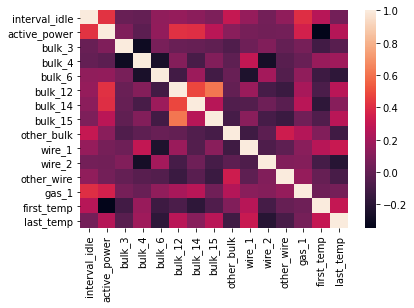

In [50]:
sns.heatmap(data_model.corr())

In [52]:
data_model

,interval_idle,active_power,bulk_3,bulk_4,bulk_6,bulk_12,bulk_14,bulk_15,other_bulk,wire_1,wire_2,other_wire,gas_1,first_temp,last_temp
0,485.0,628.616930,0.0,43.0,0.0,206.0,150.0,154.0,0.0,60.059998,0.00000,0.0,29.749986,1571.0,1613.0
1,333.0,395.281800,0.0,73.0,0.0,206.0,149.0,154.0,0.0,96.052315,0.00000,0.0,12.555561,1581.0,1602.0
2,870.0,581.774624,0.0,34.0,0.0,205.0,152.0,153.0,0.0,91.160157,0.00000,0.0,28.554793,1596.0,1599.0
3,352.0,543.710274,0.0,81.0,0.0,207.0,153.0,154.0,0.0,89.063515,0.00000,0.0,18.841219,1601.0,1625.0
4,493.0,412.180480,0.0,78.0,0.0,203.0,151.0,152.0,0.0,89.238236,9.11456,0.0,5.413692,1576.0,1602.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324,485.0,571.539318,21.0,0.0,0.0,256.0,129.0,223.0,90.0,89.150879,0.00000,0.0,7.125735,1570.0,1591.0
2325,629.0,675.222467,0.0,63.0,0.0,256.0,129.0,226.0,122.0,114.179527,0.00000,0.0,9.412616,1554.0,1591.0
2326,255.0,680.326674,0.0,85.0,0.0,230.0,124.0,226.0,0.0,94.086723,9.04800,0.0,6.271699,1571.0,1589.0
2327,608.0,474.918795,90.0,0.0,0.0,206.0,129.0,207.0,101.0,118.110717,0.00000,0.0,14.953657,1591.0,1594.0


### Вывод
Из начальных данных получили датафрейм data_model, который будем использовать при обучении и тестировании моделей.

## Построение модели.
Требуемое значение точности модели MAE < 6.8 (среднее абсолютное отклонение).  
В качестве моделей исследуем:  
- линейную регрессию;
- модель LightGBM;
- модель случайный лес.
Проверим результат на константной модели.
### Разделение на тестовую и тренировочную выборку.

Выделим целевой признак.

In [51]:
data_model_features = data_model.drop(columns=['last_temp'],axis=1)
data_model_target = data_model['last_temp']

Разделим на тестовую и тренировочную выборку.

In [52]:
features_train_valid, features_test, target_train_valid, target_test = train_test_split(data_model_features
                                                                                        ,data_model_target
                                                                                        ,random_state=RANDOM_STATE
                                                                                        ,test_size=TEST_SIZE)

### Модель линейной регрессии

In [53]:
model_linear = LinearRegression()

scores = cross_val_score(model_linear,features_train_valid,target_train_valid,cv=5,scoring='neg_mean_absolute_error')
final_score = abs(sum(scores)/len(scores))
print('Среднее абсолютное отклонение для модели линейной регрессии равно: ',final_score)

Среднее абсолютное отклонение для модели линейной регрессии равно:  6.526185799756831


### Модель LightGBM

In [54]:
def obj(trial):
    params = {'verbosity':-1
              ,'n_estimators':trial.suggest_int('n_estimators',50,1000,step=10)
             ,'max_depth':trial.suggest_int('max_depth',5,100,step=5)
              ,'num_leaves':trial.suggest_int('num_leaves',5,105,step=5)
              ,'learning_rate':trial.suggest_float('learning_rate',.001,.251,step=.01)
              ,'random_state':RANDOM_STATE
             }
    model_lgm = LGBMRegressor(**params)
    scores = cross_val_score(model_lgm,features_train_valid,target_train_valid,cv=4,scoring='neg_mean_absolute_error')
    final_score = abs(sum(scores)/len(scores))
    print(final_score)
    
    return final_score

study = optuna.create_study()
study.optimize(obj,n_trials=150)

[I 2023-05-18 11:43:20,438] A new study created in memory with name: no-name-2175d7ad-bc8d-4425-99cb-20e050130083
[I 2023-05-18 11:43:21,378] Trial 0 finished with value: 6.705716919111509 and parameters: {'n_estimators': 130, 'max_depth': 25, 'num_leaves': 55, 'learning_rate': 0.101}. Best is trial 0 with value: 6.705716919111509.


6.705716919111509


[I 2023-05-18 11:43:23,092] Trial 1 finished with value: 6.64545139415517 and parameters: {'n_estimators': 280, 'max_depth': 60, 'num_leaves': 90, 'learning_rate': 0.041}. Best is trial 1 with value: 6.64545139415517.


6.64545139415517


[I 2023-05-18 11:43:23,372] Trial 2 finished with value: 6.516473150134054 and parameters: {'n_estimators': 210, 'max_depth': 50, 'num_leaves': 5, 'learning_rate': 0.151}. Best is trial 2 with value: 6.516473150134054.


6.516473150134054


[I 2023-05-18 11:43:24,441] Trial 3 finished with value: 7.687649592609262 and parameters: {'n_estimators': 190, 'max_depth': 50, 'num_leaves': 70, 'learning_rate': 0.001}. Best is trial 2 with value: 6.516473150134054.


7.687649592609262


[I 2023-05-18 11:43:25,341] Trial 4 finished with value: 6.981901339006551 and parameters: {'n_estimators': 140, 'max_depth': 100, 'num_leaves': 75, 'learning_rate': 0.181}. Best is trial 2 with value: 6.516473150134054.


6.981901339006551


[I 2023-05-18 11:43:29,354] Trial 5 finished with value: 6.775043651605271 and parameters: {'n_estimators': 630, 'max_depth': 80, 'num_leaves': 95, 'learning_rate': 0.091}. Best is trial 2 with value: 6.516473150134054.


6.775043651605271


[I 2023-05-18 11:43:32,286] Trial 6 finished with value: 6.741553995057583 and parameters: {'n_estimators': 470, 'max_depth': 25, 'num_leaves': 40, 'learning_rate': 0.051000000000000004}. Best is trial 2 with value: 6.516473150134054.


6.741553995057583


[I 2023-05-18 11:43:33,280] Trial 7 finished with value: 6.94048178558878 and parameters: {'n_estimators': 160, 'max_depth': 20, 'num_leaves': 65, 'learning_rate': 0.201}. Best is trial 2 with value: 6.516473150134054.


6.94048178558878


[I 2023-05-18 11:43:34,276] Trial 8 finished with value: 6.8135266398894725 and parameters: {'n_estimators': 830, 'max_depth': 30, 'num_leaves': 5, 'learning_rate': 0.14100000000000001}. Best is trial 2 with value: 6.516473150134054.


6.8135266398894725


[I 2023-05-18 11:43:38,369] Trial 9 finished with value: 7.1383153275742455 and parameters: {'n_estimators': 650, 'max_depth': 45, 'num_leaves': 70, 'learning_rate': 0.241}. Best is trial 2 with value: 6.516473150134054.


7.1383153275742455


[I 2023-05-18 11:43:38,855] Trial 10 finished with value: 6.622482917720826 and parameters: {'n_estimators': 390, 'max_depth': 70, 'num_leaves': 5, 'learning_rate': 0.151}. Best is trial 2 with value: 6.516473150134054.


6.622482917720826


[I 2023-05-18 11:43:39,331] Trial 11 finished with value: 6.622482917720826 and parameters: {'n_estimators': 390, 'max_depth': 70, 'num_leaves': 5, 'learning_rate': 0.151}. Best is trial 2 with value: 6.516473150134054.


6.622482917720826


[I 2023-05-18 11:43:40,688] Trial 12 finished with value: 6.961086828819479 and parameters: {'n_estimators': 330, 'max_depth': 85, 'num_leaves': 30, 'learning_rate': 0.191}. Best is trial 2 with value: 6.516473150134054.


6.961086828819479


[I 2023-05-18 11:43:41,685] Trial 13 finished with value: 6.8233918992058475 and parameters: {'n_estimators': 550, 'max_depth': 5, 'num_leaves': 25, 'learning_rate': 0.111}. Best is trial 2 with value: 6.516473150134054.
[I 2023-05-18 11:43:41,894] Trial 14 finished with value: 6.766133858842793 and parameters: {'n_estimators': 50, 'max_depth': 60, 'num_leaves': 20, 'learning_rate': 0.251}. Best is trial 2 with value: 6.516473150134054.


6.8233918992058475
6.766133858842793


[I 2023-05-18 11:43:44,060] Trial 15 finished with value: 7.051450865971865 and parameters: {'n_estimators': 950, 'max_depth': 45, 'num_leaves': 15, 'learning_rate': 0.161}. Best is trial 2 with value: 6.516473150134054.


7.051450865971865


[I 2023-05-18 11:43:46,346] Trial 16 finished with value: 6.8010774958514295 and parameters: {'n_estimators': 430, 'max_depth': 75, 'num_leaves': 40, 'learning_rate': 0.07100000000000001}. Best is trial 2 with value: 6.516473150134054.


6.8010774958514295


[I 2023-05-18 11:43:48,014] Trial 17 finished with value: 6.968256858373552 and parameters: {'n_estimators': 280, 'max_depth': 90, 'num_leaves': 40, 'learning_rate': 0.221}. Best is trial 2 with value: 6.516473150134054.


6.968256858373552


[I 2023-05-18 11:43:49,048] Trial 18 finished with value: 6.836824236163109 and parameters: {'n_estimators': 560, 'max_depth': 65, 'num_leaves': 10, 'learning_rate': 0.131}. Best is trial 2 with value: 6.516473150134054.


6.836824236163109


[I 2023-05-18 11:43:52,144] Trial 19 finished with value: 6.95632936480911 and parameters: {'n_estimators': 730, 'max_depth': 35, 'num_leaves': 30, 'learning_rate': 0.171}. Best is trial 2 with value: 6.516473150134054.


6.95632936480911


[I 2023-05-18 11:43:54,316] Trial 20 finished with value: 6.967335966871103 and parameters: {'n_estimators': 330, 'max_depth': 55, 'num_leaves': 105, 'learning_rate': 0.211}. Best is trial 2 with value: 6.516473150134054.


6.967335966871103


[I 2023-05-18 11:43:54,846] Trial 21 finished with value: 6.621610055936559 and parameters: {'n_estimators': 430, 'max_depth': 70, 'num_leaves': 5, 'learning_rate': 0.14100000000000001}. Best is trial 2 with value: 6.516473150134054.


6.621610055936559


[I 2023-05-18 11:43:55,950] Trial 22 finished with value: 6.864795096413186 and parameters: {'n_estimators': 490, 'max_depth': 70, 'num_leaves': 15, 'learning_rate': 0.121}. Best is trial 2 with value: 6.516473150134054.


6.864795096413186


[I 2023-05-18 11:43:56,329] Trial 23 finished with value: 6.526954834392853 and parameters: {'n_estimators': 240, 'max_depth': 95, 'num_leaves': 5, 'learning_rate': 0.151}. Best is trial 2 with value: 6.516473150134054.


6.526954834392853


[I 2023-05-18 11:43:57,122] Trial 24 finished with value: 6.846028600165265 and parameters: {'n_estimators': 260, 'max_depth': 95, 'num_leaves': 20, 'learning_rate': 0.131}. Best is trial 2 with value: 6.516473150134054.
[I 2023-05-18 11:43:57,324] Trial 25 finished with value: 6.559968244137564 and parameters: {'n_estimators': 60, 'max_depth': 85, 'num_leaves': 15, 'learning_rate': 0.171}. Best is trial 2 with value: 6.516473150134054.


6.846028600165265
6.559968244137564


[I 2023-05-18 11:43:57,681] Trial 26 finished with value: 6.6979013107339185 and parameters: {'n_estimators': 50, 'max_depth': 100, 'num_leaves': 50, 'learning_rate': 0.181}. Best is trial 2 with value: 6.516473150134054.


6.6979013107339185


[I 2023-05-18 11:43:58,196] Trial 27 finished with value: 6.843844692217256 and parameters: {'n_estimators': 210, 'max_depth': 90, 'num_leaves': 15, 'learning_rate': 0.221}. Best is trial 2 with value: 6.516473150134054.


6.843844692217256


[I 2023-05-18 11:43:58,714] Trial 28 finished with value: 6.745658941893456 and parameters: {'n_estimators': 110, 'max_depth': 80, 'num_leaves': 30, 'learning_rate': 0.161}. Best is trial 2 with value: 6.516473150134054.


6.745658941893456


[I 2023-05-18 11:43:59,451] Trial 29 finished with value: 6.745727307372862 and parameters: {'n_estimators': 110, 'max_depth': 40, 'num_leaves': 50, 'learning_rate': 0.101}. Best is trial 2 with value: 6.516473150134054.


6.745727307372862


[I 2023-05-18 11:44:00,124] Trial 30 finished with value: 6.5817782766068245 and parameters: {'n_estimators': 210, 'max_depth': 90, 'num_leaves': 20, 'learning_rate': 0.091}. Best is trial 2 with value: 6.516473150134054.


6.5817782766068245


[I 2023-05-18 11:44:00,850] Trial 31 finished with value: 6.608012475817325 and parameters: {'n_estimators': 210, 'max_depth': 90, 'num_leaves': 20, 'learning_rate': 0.081}. Best is trial 2 with value: 6.516473150134054.


6.608012475817325


[I 2023-05-18 11:44:01,376] Trial 32 finished with value: 6.540285181776233 and parameters: {'n_estimators': 240, 'max_depth': 80, 'num_leaves': 10, 'learning_rate': 0.111}. Best is trial 2 with value: 6.516473150134054.


6.540285181776233


[I 2023-05-18 11:44:02,022] Trial 33 finished with value: 6.640065069008065 and parameters: {'n_estimators': 320, 'max_depth': 80, 'num_leaves': 10, 'learning_rate': 0.111}. Best is trial 2 with value: 6.516473150134054.


6.640065069008065


[I 2023-05-18 11:44:02,326] Trial 34 finished with value: 6.5533177190780245 and parameters: {'n_estimators': 90, 'max_depth': 55, 'num_leaves': 10, 'learning_rate': 0.171}. Best is trial 2 with value: 6.516473150134054.


6.5533177190780245


[I 2023-05-18 11:44:03,008] Trial 35 finished with value: 6.665528760563205 and parameters: {'n_estimators': 260, 'max_depth': 55, 'num_leaves': 10, 'learning_rate': 0.011}. Best is trial 2 with value: 6.516473150134054.


6.665528760563205


[I 2023-05-18 11:44:03,589] Trial 36 finished with value: 6.723984292676677 and parameters: {'n_estimators': 140, 'max_depth': 50, 'num_leaves': 25, 'learning_rate': 0.121}. Best is trial 2 with value: 6.516473150134054.


6.723984292676677


[I 2023-05-18 11:44:04,569] Trial 37 finished with value: 6.586332576808945 and parameters: {'n_estimators': 170, 'max_depth': 60, 'num_leaves': 35, 'learning_rate': 0.061}. Best is trial 2 with value: 6.516473150134054.


6.586332576808945


[I 2023-05-18 11:44:04,843] Trial 38 finished with value: 6.537140766878342 and parameters: {'n_estimators': 100, 'max_depth': 100, 'num_leaves': 10, 'learning_rate': 0.181}. Best is trial 2 with value: 6.516473150134054.


6.537140766878342


[I 2023-05-18 11:44:06,875] Trial 39 finished with value: 6.975522840492072 and parameters: {'n_estimators': 240, 'max_depth': 100, 'num_leaves': 80, 'learning_rate': 0.201}. Best is trial 2 with value: 6.516473150134054.


6.975522840492072


[I 2023-05-18 11:44:07,344] Trial 40 finished with value: 6.567924106778023 and parameters: {'n_estimators': 320, 'max_depth': 95, 'num_leaves': 5, 'learning_rate': 0.021}. Best is trial 2 with value: 6.516473150134054.


6.567924106778023


[I 2023-05-18 11:44:07,618] Trial 41 finished with value: 6.537140766878342 and parameters: {'n_estimators': 100, 'max_depth': 100, 'num_leaves': 10, 'learning_rate': 0.181}. Best is trial 2 with value: 6.516473150134054.


6.537140766878342


[I 2023-05-18 11:44:07,984] Trial 42 finished with value: 6.661867996179084 and parameters: {'n_estimators': 170, 'max_depth': 100, 'num_leaves': 10, 'learning_rate': 0.191}. Best is trial 2 with value: 6.516473150134054.
[I 2023-05-18 11:44:08,191] Trial 43 finished with value: 6.522789331768217 and parameters: {'n_estimators': 130, 'max_depth': 95, 'num_leaves': 5, 'learning_rate': 0.151}. Best is trial 2 with value: 6.516473150134054.


6.661867996179084
6.522789331768217


[I 2023-05-18 11:44:09,079] Trial 44 finished with value: 6.826581327149118 and parameters: {'n_estimators': 140, 'max_depth': 95, 'num_leaves': 60, 'learning_rate': 0.151}. Best is trial 2 with value: 6.516473150134054.
[I 2023-05-18 11:44:09,243] Trial 45 finished with value: 6.507997526226051 and parameters: {'n_estimators': 90, 'max_depth': 100, 'num_leaves': 5, 'learning_rate': 0.191}. Best is trial 45 with value: 6.507997526226051.


6.826581327149118
6.507997526226051


[I 2023-05-18 11:44:09,506] Trial 46 finished with value: 6.506486026920678 and parameters: {'n_estimators': 170, 'max_depth': 85, 'num_leaves': 5, 'learning_rate': 0.14100000000000001}. Best is trial 46 with value: 6.506486026920678.


6.506486026920678


[I 2023-05-18 11:44:09,786] Trial 47 finished with value: 6.515485831114486 and parameters: {'n_estimators': 190, 'max_depth': 85, 'num_leaves': 5, 'learning_rate': 0.14100000000000001}. Best is trial 46 with value: 6.506486026920678.


6.515485831114486


[I 2023-05-18 11:44:10,403] Trial 48 finished with value: 6.762420424460325 and parameters: {'n_estimators': 170, 'max_depth': 85, 'num_leaves': 25, 'learning_rate': 0.14100000000000001}. Best is trial 46 with value: 6.506486026920678.


6.762420424460325


[I 2023-05-18 11:44:10,861] Trial 49 finished with value: 6.642087901390927 and parameters: {'n_estimators': 370, 'max_depth': 20, 'num_leaves': 5, 'learning_rate': 0.161}. Best is trial 46 with value: 6.506486026920678.


6.642087901390927


[I 2023-05-18 11:44:11,617] Trial 50 finished with value: 6.864641091766536 and parameters: {'n_estimators': 290, 'max_depth': 75, 'num_leaves': 15, 'learning_rate': 0.14100000000000001}. Best is trial 46 with value: 6.506486026920678.


6.864641091766536


[I 2023-05-18 11:44:11,885] Trial 51 finished with value: 6.511207718036563 and parameters: {'n_estimators': 190, 'max_depth': 95, 'num_leaves': 5, 'learning_rate': 0.161}. Best is trial 46 with value: 6.506486026920678.


6.511207718036563


[I 2023-05-18 11:44:12,198] Trial 52 finished with value: 6.511207718036563 and parameters: {'n_estimators': 190, 'max_depth': 85, 'num_leaves': 5, 'learning_rate': 0.161}. Best is trial 46 with value: 6.506486026920678.


6.511207718036563


[I 2023-05-18 11:44:12,718] Trial 53 finished with value: 6.770196987141062 and parameters: {'n_estimators': 190, 'max_depth': 75, 'num_leaves': 15, 'learning_rate': 0.191}. Best is trial 46 with value: 6.506486026920678.


6.770196987141062


[I 2023-05-18 11:44:13,228] Trial 54 finished with value: 6.548831223716249 and parameters: {'n_estimators': 370, 'max_depth': 85, 'num_leaves': 5, 'learning_rate': 0.131}. Best is trial 46 with value: 6.506486026920678.


6.548831223716249


[I 2023-05-18 11:44:19,417] Trial 55 finished with value: 6.926879223756064 and parameters: {'n_estimators': 940, 'max_depth': 65, 'num_leaves': 85, 'learning_rate': 0.161}. Best is trial 46 with value: 6.506486026920678.


6.926879223756064


[I 2023-05-18 11:44:19,737] Trial 56 finished with value: 6.648823919893521 and parameters: {'n_estimators': 70, 'max_depth': 80, 'num_leaves': 20, 'learning_rate': 0.201}. Best is trial 46 with value: 6.506486026920678.


6.648823919893521


[I 2023-05-18 11:44:22,629] Trial 57 finished with value: 6.92745295090698 and parameters: {'n_estimators': 690, 'max_depth': 45, 'num_leaves': 25, 'learning_rate': 0.14100000000000001}. Best is trial 46 with value: 6.506486026920678.


6.92745295090698


[I 2023-05-18 11:44:22,917] Trial 58 finished with value: 6.508348410620251 and parameters: {'n_estimators': 210, 'max_depth': 90, 'num_leaves': 5, 'learning_rate': 0.171}. Best is trial 46 with value: 6.506486026920678.


6.508348410620251


[I 2023-05-18 11:44:23,298] Trial 59 finished with value: 6.762392403402368 and parameters: {'n_estimators': 140, 'max_depth': 85, 'num_leaves': 15, 'learning_rate': 0.221}. Best is trial 46 with value: 6.506486026920678.


6.762392403402368


[I 2023-05-18 11:44:23,671] Trial 60 finished with value: 6.5373622930472 and parameters: {'n_estimators': 290, 'max_depth': 90, 'num_leaves': 5, 'learning_rate': 0.171}. Best is trial 46 with value: 6.506486026920678.


6.5373622930472


[I 2023-05-18 11:44:23,952] Trial 61 finished with value: 6.5248341933905305 and parameters: {'n_estimators': 200, 'max_depth': 95, 'num_leaves': 5, 'learning_rate': 0.161}. Best is trial 46 with value: 6.506486026920678.


6.5248341933905305


[I 2023-05-18 11:44:24,302] Trial 62 finished with value: 6.661867996179084 and parameters: {'n_estimators': 170, 'max_depth': 90, 'num_leaves': 10, 'learning_rate': 0.191}. Best is trial 46 with value: 6.506486026920678.


6.661867996179084


[I 2023-05-18 11:44:24,898] Trial 63 finished with value: 6.70492254448507 and parameters: {'n_estimators': 230, 'max_depth': 85, 'num_leaves': 15, 'learning_rate': 0.121}. Best is trial 46 with value: 6.506486026920678.


6.70492254448507


[I 2023-05-18 11:44:25,262] Trial 64 finished with value: 6.537829693275771 and parameters: {'n_estimators': 270, 'max_depth': 65, 'num_leaves': 5, 'learning_rate': 0.171}. Best is trial 46 with value: 6.506486026920678.


6.537829693275771


[I 2023-05-18 11:44:25,828] Trial 65 finished with value: 6.755894885318452 and parameters: {'n_estimators': 80, 'max_depth': 75, 'num_leaves': 95, 'learning_rate': 0.151}. Best is trial 46 with value: 6.506486026920678.


6.755894885318452


[I 2023-05-18 11:44:26,239] Trial 66 finished with value: 6.6279106230587965 and parameters: {'n_estimators': 120, 'max_depth': 90, 'num_leaves': 20, 'learning_rate': 0.131}. Best is trial 46 with value: 6.506486026920678.


6.6279106230587965


[I 2023-05-18 11:44:26,650] Trial 67 finished with value: 6.863106828435456 and parameters: {'n_estimators': 220, 'max_depth': 95, 'num_leaves': 10, 'learning_rate': 0.231}. Best is trial 46 with value: 6.506486026920678.


6.863106828435456


[I 2023-05-18 11:44:26,924] Trial 68 finished with value: 6.550969657211563 and parameters: {'n_estimators': 180, 'max_depth': 35, 'num_leaves': 5, 'learning_rate': 0.211}. Best is trial 46 with value: 6.506486026920678.


6.550969657211563


[I 2023-05-18 11:44:31,805] Trial 69 finished with value: 6.926228599768755 and parameters: {'n_estimators': 790, 'max_depth': 80, 'num_leaves': 70, 'learning_rate': 0.161}. Best is trial 46 with value: 6.506486026920678.


6.926228599768755


[I 2023-05-18 11:44:32,549] Trial 70 finished with value: 6.890112643378127 and parameters: {'n_estimators': 420, 'max_depth': 5, 'num_leaves': 15, 'learning_rate': 0.151}. Best is trial 46 with value: 6.506486026920678.


6.890112643378127


[I 2023-05-18 11:44:32,766] Trial 71 finished with value: 6.524839979978334 and parameters: {'n_estimators': 140, 'max_depth': 95, 'num_leaves': 5, 'learning_rate': 0.151}. Best is trial 46 with value: 6.506486026920678.


6.524839979978334


[I 2023-05-18 11:44:33,084] Trial 72 finished with value: 6.636024956153065 and parameters: {'n_estimators': 150, 'max_depth': 100, 'num_leaves': 10, 'learning_rate': 0.171}. Best is trial 46 with value: 6.506486026920678.
[I 2023-05-18 11:44:33,285] Trial 73 finished with value: 6.514200051693753 and parameters: {'n_estimators': 120, 'max_depth': 95, 'num_leaves': 5, 'learning_rate': 0.14100000000000001}. Best is trial 46 with value: 6.506486026920678.


6.636024956153065
6.514200051693753


[I 2023-05-18 11:44:34,342] Trial 74 finished with value: 6.965422343443235 and parameters: {'n_estimators': 600, 'max_depth': 90, 'num_leaves': 10, 'learning_rate': 0.181}. Best is trial 46 with value: 6.506486026920678.


6.965422343443235


[I 2023-05-18 11:44:34,593] Trial 75 finished with value: 6.505667763772813 and parameters: {'n_estimators': 70, 'max_depth': 85, 'num_leaves': 15, 'learning_rate': 0.131}. Best is trial 75 with value: 6.505667763772813.
[I 2023-05-18 11:44:34,744] Trial 76 finished with value: 6.495048581189495 and parameters: {'n_estimators': 70, 'max_depth': 85, 'num_leaves': 5, 'learning_rate': 0.131}. Best is trial 76 with value: 6.495048581189495.


6.505667763772813
6.495048581189495


[I 2023-05-18 11:44:35,010] Trial 77 finished with value: 6.484384030499963 and parameters: {'n_estimators': 60, 'max_depth': 85, 'num_leaves': 20, 'learning_rate': 0.101}. Best is trial 77 with value: 6.484384030499963.


6.484384030499963


[I 2023-05-18 11:44:35,221] Trial 78 finished with value: 6.45638290840411 and parameters: {'n_estimators': 50, 'max_depth': 80, 'num_leaves': 15, 'learning_rate': 0.101}. Best is trial 78 with value: 6.45638290840411.


6.45638290840411


[I 2023-05-18 11:44:35,546] Trial 79 finished with value: 6.484384030499963 and parameters: {'n_estimators': 60, 'max_depth': 80, 'num_leaves': 20, 'learning_rate': 0.101}. Best is trial 78 with value: 6.45638290840411.


6.484384030499963


[I 2023-05-18 11:44:35,898] Trial 80 finished with value: 6.475800178396986 and parameters: {'n_estimators': 50, 'max_depth': 80, 'num_leaves': 25, 'learning_rate': 0.101}. Best is trial 78 with value: 6.45638290840411.


6.475800178396986


[I 2023-05-18 11:44:36,175] Trial 81 finished with value: 6.475800178396986 and parameters: {'n_estimators': 50, 'max_depth': 80, 'num_leaves': 25, 'learning_rate': 0.101}. Best is trial 78 with value: 6.45638290840411.


6.475800178396986


[I 2023-05-18 11:44:36,502] Trial 82 finished with value: 6.488471979963762 and parameters: {'n_estimators': 50, 'max_depth': 75, 'num_leaves': 35, 'learning_rate': 0.091}. Best is trial 78 with value: 6.45638290840411.


6.488471979963762


[I 2023-05-18 11:44:36,838] Trial 83 finished with value: 6.488471979963762 and parameters: {'n_estimators': 50, 'max_depth': 70, 'num_leaves': 35, 'learning_rate': 0.091}. Best is trial 78 with value: 6.45638290840411.


6.488471979963762


[I 2023-05-18 11:44:37,156] Trial 84 finished with value: 6.488471979963762 and parameters: {'n_estimators': 50, 'max_depth': 75, 'num_leaves': 35, 'learning_rate': 0.091}. Best is trial 78 with value: 6.45638290840411.


6.488471979963762


[I 2023-05-18 11:44:37,478] Trial 85 finished with value: 6.488471979963762 and parameters: {'n_estimators': 50, 'max_depth': 70, 'num_leaves': 35, 'learning_rate': 0.091}. Best is trial 78 with value: 6.45638290840411.


6.488471979963762


[I 2023-05-18 11:44:37,790] Trial 86 finished with value: 6.488471979963762 and parameters: {'n_estimators': 50, 'max_depth': 70, 'num_leaves': 35, 'learning_rate': 0.091}. Best is trial 78 with value: 6.45638290840411.


6.488471979963762


[I 2023-05-18 11:44:38,088] Trial 87 finished with value: 6.514530331106691 and parameters: {'n_estimators': 50, 'max_depth': 70, 'num_leaves': 35, 'learning_rate': 0.081}. Best is trial 78 with value: 6.45638290840411.


6.514530331106691


[I 2023-05-18 11:44:38,647] Trial 88 finished with value: 6.6650331695028004 and parameters: {'n_estimators': 90, 'max_depth': 75, 'num_leaves': 45, 'learning_rate': 0.101}. Best is trial 78 with value: 6.45638290840411.


6.6650331695028004


[I 2023-05-18 11:44:38,925] Trial 89 finished with value: 6.454535958821538 and parameters: {'n_estimators': 50, 'max_depth': 75, 'num_leaves': 30, 'learning_rate': 0.07100000000000001}. Best is trial 89 with value: 6.454535958821538.


6.454535958821538


[I 2023-05-18 11:44:39,444] Trial 90 finished with value: 6.507925669244371 and parameters: {'n_estimators': 110, 'max_depth': 75, 'num_leaves': 30, 'learning_rate': 0.061}. Best is trial 89 with value: 6.454535958821538.


6.507925669244371


[I 2023-05-18 11:44:39,761] Trial 91 finished with value: 6.527408833496338 and parameters: {'n_estimators': 50, 'max_depth': 80, 'num_leaves': 40, 'learning_rate': 0.081}. Best is trial 89 with value: 6.454535958821538.


6.527408833496338


[I 2023-05-18 11:44:40,157] Trial 92 finished with value: 6.524548813397376 and parameters: {'n_estimators': 80, 'max_depth': 70, 'num_leaves': 30, 'learning_rate': 0.091}. Best is trial 89 with value: 6.454535958821538.


6.524548813397376


[I 2023-05-18 11:44:40,567] Trial 93 finished with value: 6.515881962558066 and parameters: {'n_estimators': 100, 'max_depth': 60, 'num_leaves': 25, 'learning_rate': 0.07100000000000001}. Best is trial 89 with value: 6.454535958821538.


6.515881962558066


[I 2023-05-18 11:44:40,905] Trial 94 finished with value: 6.577280512532074 and parameters: {'n_estimators': 50, 'max_depth': 65, 'num_leaves': 40, 'learning_rate': 0.111}. Best is trial 89 with value: 6.454535958821538.


6.577280512532074


[I 2023-05-18 11:44:41,371] Trial 95 finished with value: 6.621247512165926 and parameters: {'n_estimators': 70, 'max_depth': 80, 'num_leaves': 45, 'learning_rate': 0.101}. Best is trial 89 with value: 6.454535958821538.


6.621247512165926


[I 2023-05-18 11:44:41,980] Trial 96 finished with value: 6.580900721060788 and parameters: {'n_estimators': 120, 'max_depth': 75, 'num_leaves': 35, 'learning_rate': 0.07100000000000001}. Best is trial 89 with value: 6.454535958821538.


6.580900721060788


[I 2023-05-18 11:44:42,353] Trial 97 finished with value: 6.502891166632157 and parameters: {'n_estimators': 80, 'max_depth': 80, 'num_leaves': 25, 'learning_rate': 0.091}. Best is trial 89 with value: 6.454535958821538.


6.502891166632157


[I 2023-05-18 11:44:42,891] Trial 98 finished with value: 6.519037740231785 and parameters: {'n_estimators': 100, 'max_depth': 70, 'num_leaves': 30, 'learning_rate': 0.081}. Best is trial 89 with value: 6.454535958821538.


6.519037740231785


[I 2023-05-18 11:44:43,198] Trial 99 finished with value: 6.494609039501522 and parameters: {'n_estimators': 50, 'max_depth': 65, 'num_leaves': 30, 'learning_rate': 0.111}. Best is trial 89 with value: 6.454535958821538.


6.494609039501522


[I 2023-05-18 11:44:43,629] Trial 100 finished with value: 6.512554448311567 and parameters: {'n_estimators': 70, 'max_depth': 75, 'num_leaves': 35, 'learning_rate': 0.041}. Best is trial 89 with value: 6.454535958821538.


6.512554448311567


[I 2023-05-18 11:44:43,995] Trial 101 finished with value: 6.5373302568925915 and parameters: {'n_estimators': 50, 'max_depth': 70, 'num_leaves': 35, 'learning_rate': 0.101}. Best is trial 89 with value: 6.454535958821538.


6.5373302568925915


[I 2023-05-18 11:44:44,387] Trial 102 finished with value: 6.462285932267113 and parameters: {'n_estimators': 100, 'max_depth': 80, 'num_leaves': 20, 'learning_rate': 0.091}. Best is trial 89 with value: 6.454535958821538.


6.462285932267113


[I 2023-05-18 11:44:44,742] Trial 103 finished with value: 6.44403609206149 and parameters: {'n_estimators': 90, 'max_depth': 80, 'num_leaves': 20, 'learning_rate': 0.091}. Best is trial 103 with value: 6.44403609206149.


6.44403609206149


[I 2023-05-18 11:44:45,091] Trial 104 finished with value: 6.430890543215522 and parameters: {'n_estimators': 90, 'max_depth': 80, 'num_leaves': 20, 'learning_rate': 0.061}. Best is trial 104 with value: 6.430890543215522.


6.430890543215522


[I 2023-05-18 11:44:45,616] Trial 105 finished with value: 6.444417050133656 and parameters: {'n_estimators': 150, 'max_depth': 80, 'num_leaves': 20, 'learning_rate': 0.061}. Best is trial 104 with value: 6.430890543215522.


6.444417050133656


[I 2023-05-18 11:44:46,116] Trial 106 finished with value: 6.444417050133656 and parameters: {'n_estimators': 150, 'max_depth': 80, 'num_leaves': 20, 'learning_rate': 0.061}. Best is trial 104 with value: 6.430890543215522.


6.444417050133656


[I 2023-05-18 11:44:46,665] Trial 107 finished with value: 6.443650314868778 and parameters: {'n_estimators': 160, 'max_depth': 80, 'num_leaves': 20, 'learning_rate': 0.061}. Best is trial 104 with value: 6.430890543215522.


6.443650314868778


[I 2023-05-18 11:44:47,172] Trial 108 finished with value: 6.450412137784012 and parameters: {'n_estimators': 150, 'max_depth': 80, 'num_leaves': 20, 'learning_rate': 0.051000000000000004}. Best is trial 104 with value: 6.430890543215522.


6.450412137784012


[I 2023-05-18 11:44:47,745] Trial 109 finished with value: 6.473840192504732 and parameters: {'n_estimators': 150, 'max_depth': 80, 'num_leaves': 25, 'learning_rate': 0.041}. Best is trial 104 with value: 6.430890543215522.


6.473840192504732


[I 2023-05-18 11:44:48,192] Trial 110 finished with value: 6.450295300255706 and parameters: {'n_estimators': 130, 'max_depth': 80, 'num_leaves': 20, 'learning_rate': 0.041}. Best is trial 104 with value: 6.430890543215522.


6.450295300255706


[I 2023-05-18 11:44:48,730] Trial 111 finished with value: 6.456669111671053 and parameters: {'n_estimators': 160, 'max_depth': 80, 'num_leaves': 20, 'learning_rate': 0.051000000000000004}. Best is trial 104 with value: 6.430890543215522.


6.456669111671053


[I 2023-05-18 11:44:49,228] Trial 112 finished with value: 6.452162896355524 and parameters: {'n_estimators': 150, 'max_depth': 80, 'num_leaves': 20, 'learning_rate': 0.041}. Best is trial 104 with value: 6.430890543215522.


6.452162896355524


[I 2023-05-18 11:44:49,667] Trial 113 finished with value: 6.436899707481378 and parameters: {'n_estimators': 130, 'max_depth': 75, 'num_leaves': 20, 'learning_rate': 0.051000000000000004}. Best is trial 104 with value: 6.430890543215522.


6.436899707481378


[I 2023-05-18 11:44:50,257] Trial 114 finished with value: 6.456669111671053 and parameters: {'n_estimators': 160, 'max_depth': 85, 'num_leaves': 20, 'learning_rate': 0.051000000000000004}. Best is trial 104 with value: 6.430890543215522.


6.456669111671053


[I 2023-05-18 11:44:50,780] Trial 115 finished with value: 6.455942127978559 and parameters: {'n_estimators': 130, 'max_depth': 75, 'num_leaves': 20, 'learning_rate': 0.031}. Best is trial 104 with value: 6.430890543215522.


6.455942127978559


[I 2023-05-18 11:44:51,308] Trial 116 finished with value: 6.57633153183364 and parameters: {'n_estimators': 130, 'max_depth': 75, 'num_leaves': 15, 'learning_rate': 0.021}. Best is trial 104 with value: 6.430890543215522.


6.57633153183364


[I 2023-05-18 11:44:51,935] Trial 117 finished with value: 6.455942127978559 and parameters: {'n_estimators': 130, 'max_depth': 75, 'num_leaves': 20, 'learning_rate': 0.031}. Best is trial 104 with value: 6.430890543215522.


6.455942127978559


[I 2023-05-18 11:44:52,587] Trial 118 finished with value: 6.438946220738947 and parameters: {'n_estimators': 130, 'max_depth': 75, 'num_leaves': 25, 'learning_rate': 0.031}. Best is trial 104 with value: 6.430890543215522.


6.438946220738947


[I 2023-05-18 11:44:53,425] Trial 119 finished with value: 6.487764858520478 and parameters: {'n_estimators': 150, 'max_depth': 75, 'num_leaves': 25, 'learning_rate': 0.061}. Best is trial 104 with value: 6.430890543215522.


6.487764858520478


[I 2023-05-18 11:44:54,313] Trial 120 finished with value: 6.473159663431472 and parameters: {'n_estimators': 240, 'max_depth': 75, 'num_leaves': 20, 'learning_rate': 0.041}. Best is trial 104 with value: 6.430890543215522.


6.473159663431472


[I 2023-05-18 11:44:54,806] Trial 121 finished with value: 6.455942127978559 and parameters: {'n_estimators': 130, 'max_depth': 75, 'num_leaves': 20, 'learning_rate': 0.031}. Best is trial 104 with value: 6.430890543215522.


6.455942127978559


[I 2023-05-18 11:44:55,646] Trial 122 finished with value: 6.502818684479408 and parameters: {'n_estimators': 190, 'max_depth': 80, 'num_leaves': 25, 'learning_rate': 0.051000000000000004}. Best is trial 104 with value: 6.430890543215522.


6.502818684479408


[I 2023-05-18 11:44:56,109] Trial 123 finished with value: 6.517569350091398 and parameters: {'n_estimators': 110, 'max_depth': 85, 'num_leaves': 15, 'learning_rate': 0.031}. Best is trial 104 with value: 6.430890543215522.


6.517569350091398


[I 2023-05-18 11:44:56,570] Trial 124 finished with value: 6.455942127978559 and parameters: {'n_estimators': 130, 'max_depth': 75, 'num_leaves': 20, 'learning_rate': 0.031}. Best is trial 104 with value: 6.430890543215522.


6.455942127978559


[I 2023-05-18 11:44:57,023] Trial 125 finished with value: 6.51210931973338 and parameters: {'n_estimators': 160, 'max_depth': 80, 'num_leaves': 15, 'learning_rate': 0.061}. Best is trial 104 with value: 6.430890543215522.


6.51210931973338


[I 2023-05-18 11:44:57,893] Trial 126 finished with value: 7.681156716348443 and parameters: {'n_estimators': 210, 'max_depth': 75, 'num_leaves': 25, 'learning_rate': 0.001}. Best is trial 104 with value: 6.430890543215522.


7.681156716348443


[I 2023-05-18 11:44:58,527] Trial 127 finished with value: 6.448109817650467 and parameters: {'n_estimators': 180, 'max_depth': 80, 'num_leaves': 20, 'learning_rate': 0.021}. Best is trial 104 with value: 6.430890543215522.


6.448109817650467


[I 2023-05-18 11:44:59,327] Trial 128 finished with value: 6.657240362319762 and parameters: {'n_estimators': 150, 'max_depth': 85, 'num_leaves': 30, 'learning_rate': 0.011}. Best is trial 104 with value: 6.430890543215522.


6.657240362319762


[I 2023-05-18 11:44:59,808] Trial 129 finished with value: 6.472767655830768 and parameters: {'n_estimators': 170, 'max_depth': 80, 'num_leaves': 15, 'learning_rate': 0.041}. Best is trial 104 with value: 6.430890543215522.


6.472767655830768


[I 2023-05-18 11:45:00,455] Trial 130 finished with value: 6.448109817650467 and parameters: {'n_estimators': 180, 'max_depth': 85, 'num_leaves': 20, 'learning_rate': 0.021}. Best is trial 104 with value: 6.430890543215522.


6.448109817650467


[I 2023-05-18 11:45:01,072] Trial 131 finished with value: 6.457844814363551 and parameters: {'n_estimators': 180, 'max_depth': 85, 'num_leaves': 20, 'learning_rate': 0.051000000000000004}. Best is trial 104 with value: 6.430890543215522.


6.457844814363551


[I 2023-05-18 11:45:01,862] Trial 132 finished with value: 6.447104302287215 and parameters: {'n_estimators': 220, 'max_depth': 10, 'num_leaves': 25, 'learning_rate': 0.021}. Best is trial 104 with value: 6.430890543215522.


6.447104302287215


[I 2023-05-18 11:45:02,697] Trial 133 finished with value: 6.436218927223429 and parameters: {'n_estimators': 230, 'max_depth': 30, 'num_leaves': 25, 'learning_rate': 0.021}. Best is trial 104 with value: 6.430890543215522.


6.436218927223429


[I 2023-05-18 11:45:03,580] Trial 134 finished with value: 6.431115810701698 and parameters: {'n_estimators': 230, 'max_depth': 15, 'num_leaves': 25, 'learning_rate': 0.021}. Best is trial 104 with value: 6.430890543215522.


6.431115810701698


[I 2023-05-18 11:45:04,405] Trial 135 finished with value: 6.45321897975211 and parameters: {'n_estimators': 240, 'max_depth': 10, 'num_leaves': 25, 'learning_rate': 0.021}. Best is trial 104 with value: 6.430890543215522.


6.45321897975211


[I 2023-05-18 11:45:05,208] Trial 136 finished with value: 6.526083057266204 and parameters: {'n_estimators': 220, 'max_depth': 10, 'num_leaves': 25, 'learning_rate': 0.011}. Best is trial 104 with value: 6.430890543215522.


6.526083057266204


[I 2023-05-18 11:45:06,225] Trial 137 finished with value: 6.439545103197824 and parameters: {'n_estimators': 260, 'max_depth': 15, 'num_leaves': 25, 'learning_rate': 0.021}. Best is trial 104 with value: 6.430890543215522.


6.439545103197824


[I 2023-05-18 11:45:07,335] Trial 138 finished with value: 6.438958988495517 and parameters: {'n_estimators': 260, 'max_depth': 20, 'num_leaves': 25, 'learning_rate': 0.021}. Best is trial 104 with value: 6.430890543215522.


6.438958988495517


[I 2023-05-18 11:45:08,826] Trial 139 finished with value: 7.540966849974154 and parameters: {'n_estimators': 300, 'max_depth': 20, 'num_leaves': 30, 'learning_rate': 0.001}. Best is trial 104 with value: 6.430890543215522.


7.540966849974154


[I 2023-05-18 11:45:09,805] Trial 140 finished with value: 6.431115810701698 and parameters: {'n_estimators': 230, 'max_depth': 15, 'num_leaves': 25, 'learning_rate': 0.021}. Best is trial 104 with value: 6.430890543215522.


6.431115810701698


[I 2023-05-18 11:45:10,767] Trial 141 finished with value: 6.439545103197824 and parameters: {'n_estimators': 260, 'max_depth': 15, 'num_leaves': 25, 'learning_rate': 0.021}. Best is trial 104 with value: 6.430890543215522.


6.439545103197824


[I 2023-05-18 11:45:11,761] Trial 142 finished with value: 6.484348702810008 and parameters: {'n_estimators': 270, 'max_depth': 15, 'num_leaves': 25, 'learning_rate': 0.011}. Best is trial 104 with value: 6.430890543215522.


6.484348702810008


[I 2023-05-18 11:45:13,002] Trial 143 finished with value: 6.467498154137066 and parameters: {'n_estimators': 310, 'max_depth': 15, 'num_leaves': 30, 'learning_rate': 0.021}. Best is trial 104 with value: 6.430890543215522.


6.467498154137066


[I 2023-05-18 11:45:14,008] Trial 144 finished with value: 6.492431749768549 and parameters: {'n_estimators': 260, 'max_depth': 25, 'num_leaves': 25, 'learning_rate': 0.011}. Best is trial 104 with value: 6.430890543215522.


6.492431749768549


[I 2023-05-18 11:45:14,962] Trial 145 finished with value: 6.439545103197824 and parameters: {'n_estimators': 260, 'max_depth': 15, 'num_leaves': 25, 'learning_rate': 0.021}. Best is trial 104 with value: 6.430890543215522.


6.439545103197824


[I 2023-05-18 11:45:15,895] Trial 146 finished with value: 6.503253804947632 and parameters: {'n_estimators': 250, 'max_depth': 15, 'num_leaves': 25, 'learning_rate': 0.011}. Best is trial 104 with value: 6.430890543215522.


6.503253804947632


[I 2023-05-18 11:45:17,028] Trial 147 finished with value: 6.43834402117391 and parameters: {'n_estimators': 290, 'max_depth': 10, 'num_leaves': 30, 'learning_rate': 0.021}. Best is trial 104 with value: 6.430890543215522.


6.43834402117391


[I 2023-05-18 11:45:18,424] Trial 148 finished with value: 6.534074960052471 and parameters: {'n_estimators': 340, 'max_depth': 20, 'num_leaves': 30, 'learning_rate': 0.031}. Best is trial 104 with value: 6.430890543215522.


6.534074960052471


[I 2023-05-18 11:45:19,417] Trial 149 finished with value: 7.5788609625049155 and parameters: {'n_estimators': 280, 'max_depth': 15, 'num_leaves': 25, 'learning_rate': 0.001}. Best is trial 104 with value: 6.430890543215522.


7.5788609625049155


In [55]:
study.best_params

{'n_estimators': 90, 'max_depth': 80, 'num_leaves': 20, 'learning_rate': 0.061}

### Модель случайный лес

In [56]:
def obj_tree(trial):
    params = {'random_state':RANDOM_STATE
              ,'n_estimators':trial.suggest_int('n_estimators',50,150,step=10)
             ,'max_depth':trial.suggest_int('max_depth',5,100,step=5)
              ,'min_samples_split':trial.suggest_int('min_samples_split',2,10,step=1)
              ,'min_samples_leaf':trial.suggest_int('min_samples_leaf',1,10,step=1)
             }
    model_tree = RandomForestRegressor(**params)
    scores = cross_val_score(model_tree,features_train_valid,target_train_valid,cv=4,scoring='neg_mean_absolute_error')
    final_score = abs(sum(scores)/len(scores))
    print(final_score)
    
    return final_score

study_tree = optuna.create_study()
study_tree.optimize(obj_tree,n_trials=150)

[I 2023-05-18 11:45:19,470] A new study created in memory with name: no-name-b52e57f6-a294-4425-a53b-47d425e605a8
[I 2023-05-18 11:45:26,962] Trial 0 finished with value: 6.5137195639759495 and parameters: {'n_estimators': 140, 'max_depth': 95, 'min_samples_split': 5, 'min_samples_leaf': 5}. Best is trial 0 with value: 6.5137195639759495.


6.5137195639759495


[I 2023-05-18 11:45:30,905] Trial 1 finished with value: 6.56583124337128 and parameters: {'n_estimators': 90, 'max_depth': 50, 'min_samples_split': 9, 'min_samples_leaf': 9}. Best is trial 0 with value: 6.5137195639759495.


6.56583124337128


[I 2023-05-18 11:45:34,710] Trial 2 finished with value: 6.561348165714123 and parameters: {'n_estimators': 80, 'max_depth': 40, 'min_samples_split': 6, 'min_samples_leaf': 7}. Best is trial 0 with value: 6.5137195639759495.


6.561348165714123


[I 2023-05-18 11:45:39,006] Trial 3 finished with value: 6.565154583524114 and parameters: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 9}. Best is trial 0 with value: 6.5137195639759495.


6.565154583524114


[I 2023-05-18 11:45:44,927] Trial 4 finished with value: 6.5242071711202305 and parameters: {'n_estimators': 110, 'max_depth': 45, 'min_samples_split': 8, 'min_samples_leaf': 5}. Best is trial 0 with value: 6.5137195639759495.


6.5242071711202305


[I 2023-05-18 11:45:53,646] Trial 5 finished with value: 6.439670810873785 and parameters: {'n_estimators': 140, 'max_depth': 85, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 5 with value: 6.439670810873785.


6.439670810873785


[I 2023-05-18 11:45:59,245] Trial 6 finished with value: 6.455247328113039 and parameters: {'n_estimators': 90, 'max_depth': 95, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 5 with value: 6.439670810873785.


6.455247328113039


[I 2023-05-18 11:46:02,300] Trial 7 finished with value: 6.577636568985253 and parameters: {'n_estimators': 60, 'max_depth': 55, 'min_samples_split': 7, 'min_samples_leaf': 6}. Best is trial 5 with value: 6.439670810873785.


6.577636568985253


[I 2023-05-18 11:46:05,351] Trial 8 finished with value: 6.577636568985253 and parameters: {'n_estimators': 60, 'max_depth': 85, 'min_samples_split': 6, 'min_samples_leaf': 6}. Best is trial 5 with value: 6.439670810873785.


6.577636568985253


[I 2023-05-18 11:46:10,420] Trial 9 finished with value: 6.545940725376074 and parameters: {'n_estimators': 110, 'max_depth': 60, 'min_samples_split': 4, 'min_samples_leaf': 8}. Best is trial 5 with value: 6.439670810873785.


6.545940725376074


[I 2023-05-18 11:46:19,892] Trial 10 finished with value: 6.4357541813829755 and parameters: {'n_estimators': 150, 'max_depth': 75, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 10 with value: 6.4357541813829755.


6.4357541813829755


[I 2023-05-18 11:46:32,986] Trial 11 finished with value: 6.404739507539807 and parameters: {'n_estimators': 150, 'max_depth': 70, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 11 with value: 6.404739507539807.


6.404739507539807


[I 2023-05-18 11:46:46,034] Trial 12 finished with value: 6.404739507539807 and parameters: {'n_estimators': 150, 'max_depth': 70, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 11 with value: 6.404739507539807.


6.404739507539807


[I 2023-05-18 11:46:57,303] Trial 13 finished with value: 6.408520094663323 and parameters: {'n_estimators': 130, 'max_depth': 70, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 11 with value: 6.404739507539807.


6.408520094663323


[I 2023-05-18 11:47:08,168] Trial 14 finished with value: 6.407648873287007 and parameters: {'n_estimators': 130, 'max_depth': 25, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 11 with value: 6.404739507539807.


6.407648873287007


[I 2023-05-18 11:47:18,959] Trial 15 finished with value: 6.416335823084086 and parameters: {'n_estimators': 150, 'max_depth': 70, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 11 with value: 6.404739507539807.


6.416335823084086


[I 2023-05-18 11:47:25,799] Trial 16 finished with value: 6.506108758110505 and parameters: {'n_estimators': 120, 'max_depth': 30, 'min_samples_split': 3, 'min_samples_leaf': 4}. Best is trial 11 with value: 6.404739507539807.


6.506108758110505


[I 2023-05-18 11:47:38,930] Trial 17 finished with value: 6.404739507539807 and parameters: {'n_estimators': 150, 'max_depth': 65, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 11 with value: 6.404739507539807.


6.404739507539807


[I 2023-05-18 11:47:48,260] Trial 18 finished with value: 6.417366889570206 and parameters: {'n_estimators': 130, 'max_depth': 85, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 11 with value: 6.404739507539807.


6.417366889570206


[I 2023-05-18 11:47:56,092] Trial 19 finished with value: 6.4252169000797625 and parameters: {'n_estimators': 120, 'max_depth': 80, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 11 with value: 6.404739507539807.


6.4252169000797625


[I 2023-05-18 11:47:59,043] Trial 20 finished with value: 6.55372886817113 and parameters: {'n_estimators': 50, 'max_depth': 100, 'min_samples_split': 3, 'min_samples_leaf': 4}. Best is trial 11 with value: 6.404739507539807.


6.55372886817113


[I 2023-05-18 11:48:11,992] Trial 21 finished with value: 6.404739507539807 and parameters: {'n_estimators': 150, 'max_depth': 60, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 11 with value: 6.404739507539807.


6.404739507539807


[I 2023-05-18 11:48:24,080] Trial 22 finished with value: 6.409312303219297 and parameters: {'n_estimators': 140, 'max_depth': 65, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 11 with value: 6.404739507539807.


6.409312303219297


[I 2023-05-18 11:48:34,677] Trial 23 finished with value: 6.416335823084086 and parameters: {'n_estimators': 150, 'max_depth': 70, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 11 with value: 6.404739507539807.


6.416335823084086


[I 2023-05-18 11:48:45,495] Trial 24 finished with value: 6.4010007661286386 and parameters: {'n_estimators': 140, 'max_depth': 55, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 24 with value: 6.4010007661286386.


6.4010007661286386


[I 2023-05-18 11:48:53,457] Trial 25 finished with value: 6.494308617978961 and parameters: {'n_estimators': 140, 'max_depth': 45, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 24 with value: 6.4010007661286386.


6.494308617978961


[I 2023-05-18 11:48:58,591] Trial 26 finished with value: 6.575175898365891 and parameters: {'n_estimators': 120, 'max_depth': 35, 'min_samples_split': 3, 'min_samples_leaf': 10}. Best is trial 24 with value: 6.4010007661286386.


6.575175898365891


[I 2023-05-18 11:49:06,690] Trial 27 finished with value: 6.441831117632553 and parameters: {'n_estimators': 130, 'max_depth': 55, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 24 with value: 6.4010007661286386.


6.441831117632553


[I 2023-05-18 11:49:11,484] Trial 28 finished with value: 6.698672512441373 and parameters: {'n_estimators': 140, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 24 with value: 6.4010007661286386.


6.698672512441373


[I 2023-05-18 11:49:22,348] Trial 29 finished with value: 6.4010007661286386 and parameters: {'n_estimators': 140, 'max_depth': 90, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 24 with value: 6.4010007661286386.


6.4010007661286386


[I 2023-05-18 11:49:29,966] Trial 30 finished with value: 6.4206030660583995 and parameters: {'n_estimators': 110, 'max_depth': 95, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 24 with value: 6.4010007661286386.


6.4206030660583995


[I 2023-05-18 11:49:40,786] Trial 31 finished with value: 6.4010007661286386 and parameters: {'n_estimators': 140, 'max_depth': 80, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 24 with value: 6.4010007661286386.


6.4010007661286386


[I 2023-05-18 11:49:51,651] Trial 32 finished with value: 6.4010007661286386 and parameters: {'n_estimators': 140, 'max_depth': 80, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 24 with value: 6.4010007661286386.


6.4010007661286386


[I 2023-05-18 11:50:00,522] Trial 33 finished with value: 6.418711195694483 and parameters: {'n_estimators': 130, 'max_depth': 90, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 24 with value: 6.4010007661286386.


6.418711195694483


[I 2023-05-18 11:50:09,290] Trial 34 finished with value: 6.437125937109985 and parameters: {'n_estimators': 140, 'max_depth': 80, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 24 with value: 6.4010007661286386.


6.437125937109985


[I 2023-05-18 11:50:18,403] Trial 35 finished with value: 6.413161069289001 and parameters: {'n_estimators': 120, 'max_depth': 80, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 24 with value: 6.4010007661286386.


6.413161069289001


[I 2023-05-18 11:50:23,169] Trial 36 finished with value: 6.549893937897388 and parameters: {'n_estimators': 100, 'max_depth': 100, 'min_samples_split': 8, 'min_samples_leaf': 7}. Best is trial 24 with value: 6.4010007661286386.


6.549893937897388


[I 2023-05-18 11:50:32,061] Trial 37 finished with value: 6.418711195694483 and parameters: {'n_estimators': 130, 'max_depth': 90, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 24 with value: 6.4010007661286386.


6.418711195694483


[I 2023-05-18 11:50:40,770] Trial 38 finished with value: 6.437125937109985 and parameters: {'n_estimators': 140, 'max_depth': 90, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 24 with value: 6.4010007661286386.


6.437125937109985


[I 2023-05-18 11:50:45,563] Trial 39 finished with value: 6.534692408865585 and parameters: {'n_estimators': 90, 'max_depth': 50, 'min_samples_split': 5, 'min_samples_leaf': 5}. Best is trial 24 with value: 6.4010007661286386.


6.534692408865585


[I 2023-05-18 11:50:50,132] Trial 40 finished with value: 6.537124556332671 and parameters: {'n_estimators': 80, 'max_depth': 80, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 24 with value: 6.4010007661286386.


6.537124556332671


[I 2023-05-18 11:51:00,669] Trial 41 finished with value: 6.400522995343014 and parameters: {'n_estimators': 140, 'max_depth': 75, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 41 with value: 6.400522995343014.


6.400522995343014


[I 2023-05-18 11:51:11,097] Trial 42 finished with value: 6.404239970732808 and parameters: {'n_estimators': 140, 'max_depth': 75, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 41 with value: 6.400522995343014.


6.404239970732808


[I 2023-05-18 11:51:21,635] Trial 43 finished with value: 6.400522995343014 and parameters: {'n_estimators': 140, 'max_depth': 85, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 41 with value: 6.400522995343014.


6.400522995343014


[I 2023-05-18 11:51:30,300] Trial 44 finished with value: 6.418666443385082 and parameters: {'n_estimators': 130, 'max_depth': 20, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 41 with value: 6.400522995343014.


6.418666443385082


[I 2023-05-18 11:51:40,992] Trial 45 finished with value: 6.400522995343014 and parameters: {'n_estimators': 140, 'max_depth': 85, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 41 with value: 6.400522995343014.


6.400522995343014


[I 2023-05-18 11:51:48,439] Trial 46 finished with value: 6.448645301685186 and parameters: {'n_estimators': 120, 'max_depth': 90, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 41 with value: 6.400522995343014.


6.448645301685186


[I 2023-05-18 11:51:59,876] Trial 47 finished with value: 6.396083027172498 and parameters: {'n_estimators': 150, 'max_depth': 95, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 47 with value: 6.396083027172498.


6.396083027172498


[I 2023-05-18 11:52:06,772] Trial 48 finished with value: 6.5436148791291515 and parameters: {'n_estimators': 150, 'max_depth': 95, 'min_samples_split': 6, 'min_samples_leaf': 8}. Best is trial 47 with value: 6.396083027172498.


6.5436148791291515


[I 2023-05-18 11:52:16,925] Trial 49 finished with value: 6.419480621787379 and parameters: {'n_estimators': 150, 'max_depth': 100, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 47 with value: 6.396083027172498.


6.419480621787379


[I 2023-05-18 11:52:25,203] Trial 50 finished with value: 6.401982472019319 and parameters: {'n_estimators': 110, 'max_depth': 85, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 47 with value: 6.396083027172498.


6.401982472019319


[I 2023-05-18 11:52:35,894] Trial 51 finished with value: 6.400522995343014 and parameters: {'n_estimators': 140, 'max_depth': 90, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 47 with value: 6.396083027172498.


6.400522995343014


[I 2023-05-18 11:52:45,715] Trial 52 finished with value: 6.406101361486057 and parameters: {'n_estimators': 130, 'max_depth': 75, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 47 with value: 6.396083027172498.


6.406101361486057


[I 2023-05-18 11:52:55,922] Trial 53 finished with value: 6.419480621787379 and parameters: {'n_estimators': 150, 'max_depth': 85, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 47 with value: 6.396083027172498.


6.419480621787379


[I 2023-05-18 11:53:06,427] Trial 54 finished with value: 6.404239970732808 and parameters: {'n_estimators': 140, 'max_depth': 95, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 47 with value: 6.396083027172498.


6.404239970732808


[I 2023-05-18 11:53:17,947] Trial 55 finished with value: 6.396083027172498 and parameters: {'n_estimators': 150, 'max_depth': 65, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 47 with value: 6.396083027172498.


6.396083027172498


[I 2023-05-18 11:53:28,321] Trial 56 finished with value: 6.419087074352468 and parameters: {'n_estimators': 150, 'max_depth': 65, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 47 with value: 6.396083027172498.


6.419087074352468


[I 2023-05-18 11:53:37,744] Trial 57 finished with value: 6.4357541813829755 and parameters: {'n_estimators': 150, 'max_depth': 75, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 47 with value: 6.396083027172498.


6.4357541813829755


[I 2023-05-18 11:53:42,919] Trial 58 finished with value: 6.429114731769012 and parameters: {'n_estimators': 70, 'max_depth': 60, 'min_samples_split': 8, 'min_samples_leaf': 1}. Best is trial 47 with value: 6.396083027172498.


6.429114731769012


[I 2023-05-18 11:53:53,281] Trial 59 finished with value: 6.419087074352468 and parameters: {'n_estimators': 150, 'max_depth': 100, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 47 with value: 6.396083027172498.


6.419087074352468


[I 2023-05-18 11:53:59,864] Trial 60 finished with value: 6.537593012493816 and parameters: {'n_estimators': 130, 'max_depth': 85, 'min_samples_split': 7, 'min_samples_leaf': 6}. Best is trial 47 with value: 6.396083027172498.


6.537593012493816


[I 2023-05-18 11:54:10,616] Trial 61 finished with value: 6.400522995343014 and parameters: {'n_estimators': 140, 'max_depth': 60, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 47 with value: 6.396083027172498.


6.400522995343014


[I 2023-05-18 11:54:21,331] Trial 62 finished with value: 6.400522995343014 and parameters: {'n_estimators': 140, 'max_depth': 65, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 47 with value: 6.396083027172498.


6.400522995343014


[I 2023-05-18 11:54:32,566] Trial 63 finished with value: 6.402152826009226 and parameters: {'n_estimators': 150, 'max_depth': 75, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 47 with value: 6.396083027172498.


6.402152826009226


[I 2023-05-18 11:54:42,544] Trial 64 finished with value: 6.406101361486057 and parameters: {'n_estimators': 130, 'max_depth': 70, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 47 with value: 6.396083027172498.


6.406101361486057


[I 2023-05-18 11:54:52,124] Trial 65 finished with value: 6.4158671383546375 and parameters: {'n_estimators': 140, 'max_depth': 60, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 47 with value: 6.396083027172498.


6.4158671383546375


[I 2023-05-18 11:55:02,460] Trial 66 finished with value: 6.419087074352468 and parameters: {'n_estimators': 150, 'max_depth': 45, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 47 with value: 6.396083027172498.


6.419087074352468


[I 2023-05-18 11:55:13,247] Trial 67 finished with value: 6.400522995343014 and parameters: {'n_estimators': 140, 'max_depth': 90, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 47 with value: 6.396083027172498.


6.400522995343014


[I 2023-05-18 11:55:24,793] Trial 68 finished with value: 6.396083027172498 and parameters: {'n_estimators': 150, 'max_depth': 70, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 47 with value: 6.396083027172498.


6.396083027172498


[I 2023-05-18 11:55:35,585] Trial 69 finished with value: 6.40409629407274 and parameters: {'n_estimators': 150, 'max_depth': 70, 'min_samples_split': 9, 'min_samples_leaf': 1}. Best is trial 47 with value: 6.396083027172498.


6.40409629407274


[I 2023-05-18 11:55:45,729] Trial 70 finished with value: 6.419480621787379 and parameters: {'n_estimators': 150, 'max_depth': 85, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 47 with value: 6.396083027172498.


6.419480621787379


[I 2023-05-18 11:55:56,280] Trial 71 finished with value: 6.400522995343014 and parameters: {'n_estimators': 140, 'max_depth': 55, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 47 with value: 6.396083027172498.


6.400522995343014


[I 2023-05-18 11:56:07,262] Trial 72 finished with value: 6.4010007661286386 and parameters: {'n_estimators': 140, 'max_depth': 65, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 47 with value: 6.396083027172498.


6.4010007661286386


[I 2023-05-18 11:56:18,580] Trial 73 finished with value: 6.396083027172498 and parameters: {'n_estimators': 150, 'max_depth': 70, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 47 with value: 6.396083027172498.


6.396083027172498


[I 2023-05-18 11:56:30,175] Trial 74 finished with value: 6.3989890294918315 and parameters: {'n_estimators': 150, 'max_depth': 75, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 47 with value: 6.396083027172498.


6.3989890294918315


[I 2023-05-18 11:56:40,695] Trial 75 finished with value: 6.420328618105012 and parameters: {'n_estimators': 150, 'max_depth': 75, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 47 with value: 6.396083027172498.


6.420328618105012


[I 2023-05-18 11:56:52,815] Trial 76 finished with value: 6.39489443073365 and parameters: {'n_estimators': 150, 'max_depth': 70, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 76 with value: 6.39489443073365.


6.39489443073365


[I 2023-05-18 11:57:03,616] Trial 77 finished with value: 6.416335823084086 and parameters: {'n_estimators': 150, 'max_depth': 70, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 76 with value: 6.39489443073365.


6.416335823084086


[I 2023-05-18 11:57:15,798] Trial 78 finished with value: 6.39489443073365 and parameters: {'n_estimators': 150, 'max_depth': 65, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 76 with value: 6.39489443073365.


6.39489443073365


[I 2023-05-18 11:57:25,263] Trial 79 finished with value: 6.4357541813829755 and parameters: {'n_estimators': 150, 'max_depth': 65, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 76 with value: 6.39489443073365.


6.4357541813829755


[I 2023-05-18 11:57:36,037] Trial 80 finished with value: 6.416335823084086 and parameters: {'n_estimators': 150, 'max_depth': 70, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 76 with value: 6.39489443073365.


6.416335823084086


[I 2023-05-18 11:57:48,212] Trial 81 finished with value: 6.39489443073365 and parameters: {'n_estimators': 150, 'max_depth': 75, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 76 with value: 6.39489443073365.


6.39489443073365


[I 2023-05-18 11:58:00,330] Trial 82 finished with value: 6.39489443073365 and parameters: {'n_estimators': 150, 'max_depth': 75, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 76 with value: 6.39489443073365.


6.39489443073365


[I 2023-05-18 11:58:12,872] Trial 83 finished with value: 6.392499329049205 and parameters: {'n_estimators': 150, 'max_depth': 70, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 83 with value: 6.392499329049205.


6.392499329049205


[I 2023-05-18 11:58:25,494] Trial 84 finished with value: 6.392499329049205 and parameters: {'n_estimators': 150, 'max_depth': 65, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 83 with value: 6.392499329049205.


6.392499329049205


[I 2023-05-18 11:58:38,039] Trial 85 finished with value: 6.392499329049205 and parameters: {'n_estimators': 150, 'max_depth': 50, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 83 with value: 6.392499329049205.


6.392499329049205


[I 2023-05-18 11:58:44,499] Trial 86 finished with value: 6.571122389098765 and parameters: {'n_estimators': 150, 'max_depth': 45, 'min_samples_split': 3, 'min_samples_leaf': 10}. Best is trial 83 with value: 6.392499329049205.


6.571122389098765


[I 2023-05-18 11:58:48,801] Trial 87 finished with value: 6.413377548016746 and parameters: {'n_estimators': 50, 'max_depth': 40, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 83 with value: 6.392499329049205.


6.413377548016746


[I 2023-05-18 11:58:59,545] Trial 88 finished with value: 6.416335823084086 and parameters: {'n_estimators': 150, 'max_depth': 50, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 83 with value: 6.392499329049205.


6.416335823084086


[I 2023-05-18 11:59:11,671] Trial 89 finished with value: 6.39489443073365 and parameters: {'n_estimators': 150, 'max_depth': 60, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 83 with value: 6.392499329049205.


6.39489443073365


[I 2023-05-18 11:59:18,264] Trial 90 finished with value: 6.5532102847460045 and parameters: {'n_estimators': 150, 'max_depth': 60, 'min_samples_split': 4, 'min_samples_leaf': 9}. Best is trial 83 with value: 6.392499329049205.


6.5532102847460045


[I 2023-05-18 11:59:30,777] Trial 91 finished with value: 6.392499329049205 and parameters: {'n_estimators': 150, 'max_depth': 55, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 83 with value: 6.392499329049205.


6.392499329049205


[I 2023-05-18 11:59:43,117] Trial 92 finished with value: 6.392499329049205 and parameters: {'n_estimators': 150, 'max_depth': 50, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 83 with value: 6.392499329049205.


6.392499329049205


[I 2023-05-18 11:59:51,842] Trial 93 finished with value: 6.418029948328588 and parameters: {'n_estimators': 100, 'max_depth': 50, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 83 with value: 6.392499329049205.


6.418029948328588


[I 2023-05-18 12:00:02,585] Trial 94 finished with value: 6.416335823084086 and parameters: {'n_estimators': 150, 'max_depth': 55, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 83 with value: 6.392499329049205.


6.416335823084086


[I 2023-05-18 12:00:15,188] Trial 95 finished with value: 6.392499329049205 and parameters: {'n_estimators': 150, 'max_depth': 55, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 83 with value: 6.392499329049205.


6.392499329049205


[I 2023-05-18 12:00:25,906] Trial 96 finished with value: 6.416335823084086 and parameters: {'n_estimators': 150, 'max_depth': 40, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 83 with value: 6.392499329049205.


6.416335823084086


[I 2023-05-18 12:00:37,645] Trial 97 finished with value: 6.396722154159668 and parameters: {'n_estimators': 140, 'max_depth': 50, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 83 with value: 6.392499329049205.


6.396722154159668


[I 2023-05-18 12:00:50,680] Trial 98 finished with value: 6.404739507539807 and parameters: {'n_estimators': 150, 'max_depth': 55, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 83 with value: 6.392499329049205.


6.404739507539807


[I 2023-05-18 12:01:02,236] Trial 99 finished with value: 6.396722154159668 and parameters: {'n_estimators': 140, 'max_depth': 45, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 83 with value: 6.392499329049205.


6.396722154159668


[I 2023-05-18 12:01:12,889] Trial 100 finished with value: 6.416335823084086 and parameters: {'n_estimators': 150, 'max_depth': 55, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 83 with value: 6.392499329049205.


6.416335823084086


[I 2023-05-18 12:01:25,072] Trial 101 finished with value: 6.39489443073365 and parameters: {'n_estimators': 150, 'max_depth': 60, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 83 with value: 6.392499329049205.


6.39489443073365


[I 2023-05-18 12:01:37,637] Trial 102 finished with value: 6.392499329049205 and parameters: {'n_estimators': 150, 'max_depth': 50, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 83 with value: 6.392499329049205.


6.392499329049205


[I 2023-05-18 12:01:50,224] Trial 103 finished with value: 6.392499329049205 and parameters: {'n_estimators': 150, 'max_depth': 50, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 83 with value: 6.392499329049205.


6.392499329049205


[I 2023-05-18 12:01:57,078] Trial 104 finished with value: 6.423802069878434 and parameters: {'n_estimators': 80, 'max_depth': 50, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 83 with value: 6.392499329049205.


6.423802069878434


[I 2023-05-18 12:02:10,163] Trial 105 finished with value: 6.405111692694103 and parameters: {'n_estimators': 150, 'max_depth': 35, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 83 with value: 6.392499329049205.


6.405111692694103


[I 2023-05-18 12:02:21,965] Trial 106 finished with value: 6.396722154159668 and parameters: {'n_estimators': 140, 'max_depth': 40, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 83 with value: 6.392499329049205.


6.396722154159668


[I 2023-05-18 12:02:31,980] Trial 107 finished with value: 6.41247822567847 and parameters: {'n_estimators': 140, 'max_depth': 50, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 83 with value: 6.392499329049205.


6.41247822567847


[I 2023-05-18 12:02:39,168] Trial 108 finished with value: 6.530549513192014 and parameters: {'n_estimators': 150, 'max_depth': 45, 'min_samples_split': 3, 'min_samples_leaf': 7}. Best is trial 83 with value: 6.392499329049205.


6.530549513192014


[I 2023-05-18 12:02:52,232] Trial 109 finished with value: 6.404739507539807 and parameters: {'n_estimators': 150, 'max_depth': 55, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 83 with value: 6.392499329049205.


6.404739507539807


[I 2023-05-18 12:03:03,992] Trial 110 finished with value: 6.396722154159668 and parameters: {'n_estimators': 140, 'max_depth': 65, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 83 with value: 6.392499329049205.


6.396722154159668


[I 2023-05-18 12:03:15,928] Trial 111 finished with value: 6.39489443073365 and parameters: {'n_estimators': 150, 'max_depth': 80, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 83 with value: 6.392499329049205.


6.39489443073365


[I 2023-05-18 12:03:28,459] Trial 112 finished with value: 6.392499329049205 and parameters: {'n_estimators': 150, 'max_depth': 50, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 83 with value: 6.392499329049205.


6.392499329049205


[I 2023-05-18 12:03:33,571] Trial 113 finished with value: 6.41903931444647 and parameters: {'n_estimators': 60, 'max_depth': 50, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 83 with value: 6.392499329049205.


6.41903931444647


[I 2023-05-18 12:03:46,576] Trial 114 finished with value: 6.404739507539807 and parameters: {'n_estimators': 150, 'max_depth': 55, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 83 with value: 6.392499329049205.


6.404739507539807


[I 2023-05-18 12:03:57,339] Trial 115 finished with value: 6.416335823084086 and parameters: {'n_estimators': 150, 'max_depth': 50, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 83 with value: 6.392499329049205.


6.416335823084086


[I 2023-05-18 12:04:09,873] Trial 116 finished with value: 6.392499329049205 and parameters: {'n_estimators': 150, 'max_depth': 45, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 83 with value: 6.392499329049205.


6.392499329049205


[I 2023-05-18 12:04:17,405] Trial 117 finished with value: 6.5137195639759495 and parameters: {'n_estimators': 140, 'max_depth': 45, 'min_samples_split': 3, 'min_samples_leaf': 5}. Best is trial 83 with value: 6.392499329049205.


6.5137195639759495


[I 2023-05-18 12:04:30,428] Trial 118 finished with value: 6.404739507539807 and parameters: {'n_estimators': 150, 'max_depth': 45, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 83 with value: 6.392499329049205.


6.404739507539807


[I 2023-05-18 12:04:41,154] Trial 119 finished with value: 6.416335823084086 and parameters: {'n_estimators': 150, 'max_depth': 35, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 83 with value: 6.392499329049205.


6.416335823084086


[I 2023-05-18 12:04:52,867] Trial 120 finished with value: 6.396722154159668 and parameters: {'n_estimators': 140, 'max_depth': 40, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 83 with value: 6.392499329049205.


6.396722154159668


[I 2023-05-18 12:05:05,483] Trial 121 finished with value: 6.392499329049205 and parameters: {'n_estimators': 150, 'max_depth': 50, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 83 with value: 6.392499329049205.


6.392499329049205


[I 2023-05-18 12:05:18,103] Trial 122 finished with value: 6.392499329049205 and parameters: {'n_estimators': 150, 'max_depth': 50, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 83 with value: 6.392499329049205.


6.392499329049205


[I 2023-05-18 12:05:30,723] Trial 123 finished with value: 6.392499329049205 and parameters: {'n_estimators': 150, 'max_depth': 50, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 83 with value: 6.392499329049205.


6.392499329049205


[I 2023-05-18 12:05:43,315] Trial 124 finished with value: 6.392499329049205 and parameters: {'n_estimators': 150, 'max_depth': 50, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 83 with value: 6.392499329049205.


6.392499329049205


[I 2023-05-18 12:05:55,713] Trial 125 finished with value: 6.392499329049205 and parameters: {'n_estimators': 150, 'max_depth': 45, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 83 with value: 6.392499329049205.


6.392499329049205


[I 2023-05-18 12:06:08,303] Trial 126 finished with value: 6.392499329049205 and parameters: {'n_estimators': 150, 'max_depth': 50, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 83 with value: 6.392499329049205.


6.392499329049205


[I 2023-05-18 12:06:19,030] Trial 127 finished with value: 6.416335823084086 and parameters: {'n_estimators': 150, 'max_depth': 55, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 83 with value: 6.392499329049205.


6.416335823084086


[I 2023-05-18 12:06:31,158] Trial 128 finished with value: 6.409312303219297 and parameters: {'n_estimators': 140, 'max_depth': 45, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 83 with value: 6.392499329049205.


6.409312303219297


[I 2023-05-18 12:06:38,735] Trial 129 finished with value: 6.417403026158478 and parameters: {'n_estimators': 90, 'max_depth': 50, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 83 with value: 6.392499329049205.


6.417403026158478


[I 2023-05-18 12:06:51,163] Trial 130 finished with value: 6.392499329049205 and parameters: {'n_estimators': 150, 'max_depth': 55, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 83 with value: 6.392499329049205.


6.392499329049205


[I 2023-05-18 12:07:03,756] Trial 131 finished with value: 6.392499329049205 and parameters: {'n_estimators': 150, 'max_depth': 45, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 83 with value: 6.392499329049205.


6.392499329049205


[I 2023-05-18 12:07:16,332] Trial 132 finished with value: 6.392499329049205 and parameters: {'n_estimators': 150, 'max_depth': 50, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 83 with value: 6.392499329049205.


6.392499329049205


[I 2023-05-18 12:07:28,974] Trial 133 finished with value: 6.392499329049205 and parameters: {'n_estimators': 150, 'max_depth': 50, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 83 with value: 6.392499329049205.


6.392499329049205


[I 2023-05-18 12:07:41,572] Trial 134 finished with value: 6.392499329049205 and parameters: {'n_estimators': 150, 'max_depth': 40, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 83 with value: 6.392499329049205.


6.392499329049205


[I 2023-05-18 12:07:49,391] Trial 135 finished with value: 6.417408826707648 and parameters: {'n_estimators': 110, 'max_depth': 55, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 83 with value: 6.392499329049205.


6.417408826707648


[I 2023-05-18 12:08:01,988] Trial 136 finished with value: 6.392499329049205 and parameters: {'n_estimators': 150, 'max_depth': 50, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 83 with value: 6.392499329049205.


6.392499329049205


[I 2023-05-18 12:08:13,754] Trial 137 finished with value: 6.396722154159668 and parameters: {'n_estimators': 140, 'max_depth': 55, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 83 with value: 6.392499329049205.


6.396722154159668


[I 2023-05-18 12:08:20,669] Trial 138 finished with value: 6.5436148791291515 and parameters: {'n_estimators': 150, 'max_depth': 60, 'min_samples_split': 3, 'min_samples_leaf': 8}. Best is trial 83 with value: 6.392499329049205.


6.5436148791291515


[I 2023-05-18 12:08:32,274] Trial 139 finished with value: 6.396722154159668 and parameters: {'n_estimators': 140, 'max_depth': 45, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 83 with value: 6.392499329049205.


6.396722154159668


[I 2023-05-18 12:08:45,103] Trial 140 finished with value: 6.392499329049205 and parameters: {'n_estimators': 150, 'max_depth': 50, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 83 with value: 6.392499329049205.


6.392499329049205


[I 2023-05-18 12:08:57,806] Trial 141 finished with value: 6.392499329049205 and parameters: {'n_estimators': 150, 'max_depth': 45, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 83 with value: 6.392499329049205.


6.392499329049205


[I 2023-05-18 12:09:10,329] Trial 142 finished with value: 6.392499329049205 and parameters: {'n_estimators': 150, 'max_depth': 45, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 83 with value: 6.392499329049205.


6.392499329049205


[I 2023-05-18 12:09:22,732] Trial 143 finished with value: 6.392499329049205 and parameters: {'n_estimators': 150, 'max_depth': 55, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 83 with value: 6.392499329049205.


6.392499329049205


[I 2023-05-18 12:09:35,717] Trial 144 finished with value: 6.404739507539807 and parameters: {'n_estimators': 150, 'max_depth': 50, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 83 with value: 6.392499329049205.


6.404739507539807


[I 2023-05-18 12:09:46,432] Trial 145 finished with value: 6.416335823084086 and parameters: {'n_estimators': 150, 'max_depth': 45, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 83 with value: 6.392499329049205.


6.416335823084086


[I 2023-05-18 12:09:58,823] Trial 146 finished with value: 6.392499329049205 and parameters: {'n_estimators': 150, 'max_depth': 50, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 83 with value: 6.392499329049205.


6.392499329049205


[I 2023-05-18 12:10:11,160] Trial 147 finished with value: 6.392499329049205 and parameters: {'n_estimators': 150, 'max_depth': 40, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 83 with value: 6.392499329049205.


6.392499329049205


[I 2023-05-18 12:10:22,867] Trial 148 finished with value: 6.396722154159668 and parameters: {'n_estimators': 140, 'max_depth': 55, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 83 with value: 6.392499329049205.


6.396722154159668


[I 2023-05-18 12:10:33,628] Trial 149 finished with value: 6.416335823084086 and parameters: {'n_estimators': 150, 'max_depth': 60, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 83 with value: 6.392499329049205.


6.416335823084086


In [57]:
study_tree.best_params

{'n_estimators': 150,
 'max_depth': 70,
 'min_samples_split': 3,
 'min_samples_leaf': 1}

### Проверка на константной модели

In [58]:
model_const = DummyRegressor()

scores = cross_val_score(model_const,features_train_valid,target_train_valid,cv=5,scoring='neg_mean_absolute_error')
final_score = abs(sum(scores)/len(scores))
print('Среднее абсолютное отклонение для константной модели равно: ',final_score)

Среднее абсолютное отклонение для константной модели равно:  8.060340776596155


Обученные модели показали лучший результат, чем константная модель.

### Выбор модели

По результатам анализа можно составить следующую таблицу:

|Модель|Среднее абсолютное отклонение(МАЕ)|
|:-:|:-:|
|Линейная регрессия|6.5261|
|LightGBM|6.4308|
|Случайный лес|6.3924|

Для анализа на тестовой выборке, выберем модель случайный лес.

### Проверка качества модели на тестовой выборке

In [61]:
best_model = RandomForestRegressor(**study_tree.best_params,random_state=RANDOM_STATE)
print('Среднее абсолютное отклонение(MAE) для модели равно: '
      ,mean_absolute_error(best_model.fit(features_train_valid,target_train_valid).predict(features_test),target_test))

Среднее абсолютное отклонение(MAE) для модели равно:  6.706307558071298


### Анализ важности факторов

auto_size_plot=False is deprecated and is now ignored! Use plot_size=None instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


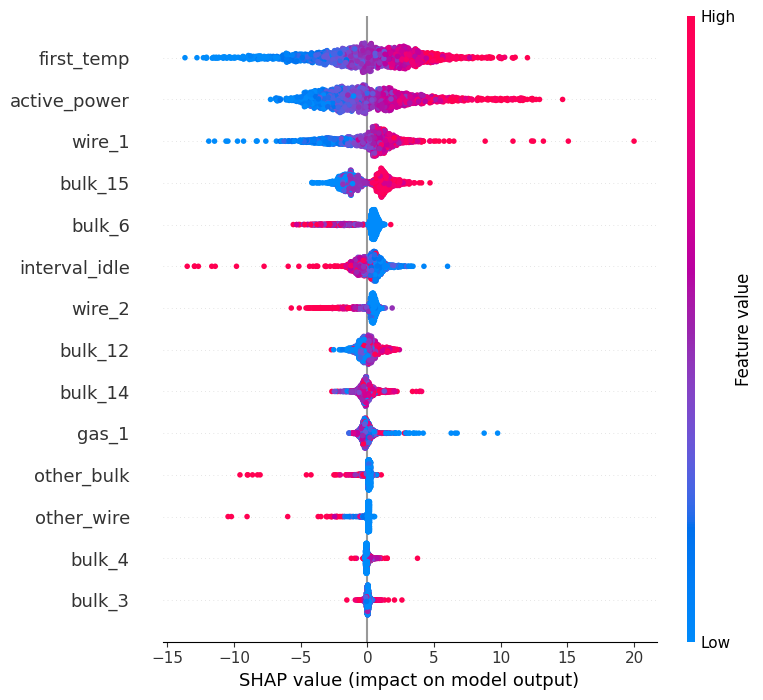

In [62]:
shap_test = shap.TreeExplainer(best_model).shap_values(features_train_valid)
shap.summary_plot(shap_test, features_train_valid,
                      max_display=25, auto_size_plot=True)

Наиболее влиятельными факторами на результирующую температуру являются первичная температура(first_temp) и затраченная энергия (active_power).

# Часть 3.
Отчёт.

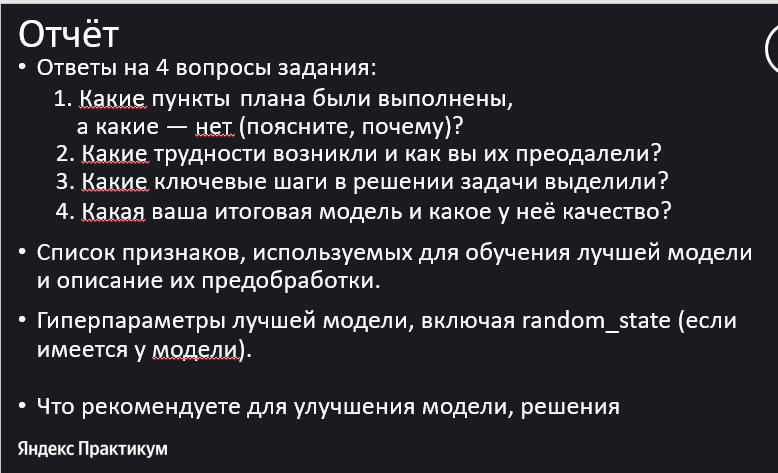

## Выполнение плана работ.  
План работ:  
1. Датафреймы объеденены в data_model. Данные очищены от неполных данных(по температуре  номеру партии)  
2. Для исследования использованы три модели (линейную регрессию,LightGBM, модель случайный лес). В качестве метрики использованна МАЕ (среднее абсолютное отклонение). Также результат сравнили с константной модели.  
3. При проверке использованна кросс-валидация. Наилучший показатель у модели случайный лес.  
4.  На тестовой выборке показатель модели случайный лес МАЕ = 6.7063  

## Признаки используемые в модели.
В качестве признаков использованы:
- начальная температура котла (first_temp);  
- активная мощность перемноженная с периодом нагрева (active_power);    
- период простоя(без нагрева) (interval_idle);  
- объём сыпучих материалов (bulk_3,bulk_4,bulk_6,bulk_12,bulk_14,bulk_15 и other_bulk, где объеденены другие из-за малого их количества);  
- объём проволочных материалах (wire_1,wire_2 и other_wire, где объеденены другие из-за малого их количества);  
-  продувке сплава газом (gas_1).  
При исследовании установленно, что наибольшее влияние на целевой признак(конечную температуру last_temp) оказывают начальная температура котла (first_temp) и активная мощность перемноженная с периодом нагрева (active_power).  						

## Гиперпараметры лучшей модели.
При исследовании наилучший результат показала модель случайный лес (RandomForestRegressor) с гиперпараметрами:  
n_estimators=150,  
max_depth=70,  
min_samples_split=3,  
min_samples_leaf=1,  
random_state=80523.  

## Рекомендации для улучшения модели.  
1. Объемы сыпучих и проволочных материалов объеденить в один столбец, но для грамотного объединения требуется какой-нибудь показатель, чем они отличаются (пример-теплопроводность).  
2. Более точный сбор данных(из-за неточности, было отсеяно практически треть первоначальных данных по ковшам).  